In [5]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
rcParams['figure.dpi']=100
rcParams['figure.figsize']=(7,5)

In [7]:
from scipy import constants as c
from scipy.integrate import quad
from scipy.linalg import null_space
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import gaussian_filter1d as gf1
from scipy import constants as c
from scipy.special import genlaguerre
from scipy.interpolate import UnivariateSpline
import numba as nb

# Functions used throughout the notebook

In [8]:
# Fermi-Dirac distribution, E and µ in µeV, T in K
def fdd(E, T, mu=0):
    return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)

# Function converts V to K
def eVtoK(V):
    return V*c.e/c.k

# Function coverts K to µeV
def toueV(T):
    return T*c.k/c.e*1e6

# Dynes density of states, all parameters should be in same units
def dynesDOS(E, dyn, delta):
    return abs(real((E+1j*dyn)/(sqrt((E+1j*dyn)**2-delta**2))))

In [9]:
# Semi-optimized SIS IV
# Delta, dynes parameter, and voltage is in µV, temperatures are in K, resistance in Ohm
# Function returns current in A
# Voltage points need to be multiples of integration points (E), i.e. if v is spaced by 0.5 µV, de= 0.25, or 0.125, but not 0.4 or 0.2 
def fast_SIS_IV(v,delta1, dyn1, T1, delta2, dyn2, T2, R):
    de = 0.5
    maxv = math.ceil(max(abs(v))/de)*de
    maxe = max(2*maxv, 5*deltaAl)
    E = arange(-maxe-maxv, maxe+maxv, de)
    mask = logical_and(E > -maxe, E < maxe)
    offset = int_((v/de).reshape(len(v), 1))
    dos2 = dynesDOS(E[mask], dyn2, delta2)
    fermi2 = fdd(E, T2)
    dos1 = dynesDOS(E[mask], dyn1, delta1)
    fermi1 = fdd(E[mask], T2)
    curr = empty(len(v))
    T = max(T1,T2)
    for i in range(len(v)):
        dos2rolled = roll(dos2, offset[i])
        fermi2rolled = roll(fermi2, offset[i])
        if v[i] < 0:
             maskv = logical_and(E[mask]>v[i]-13*c.k*T/c.e*1e6, E[mask]<+13*c.k*T/c.e*1e6)
        if v[i] >= 0:
             maskv = logical_and(E[mask]<v[i]+13*c.k*T/c.e*1e6, E[mask]>-13*c.k*T/c.e*1e6)
        curr[i] = trapz(dos2rolled[maskv]*dos1[maskv]*(fermi2rolled[mask][maskv]-fermi1[maskv]))*de/R*1e-6
    return curr

In [10]:
# Semi-optimized SIN IV
# Delta, dynes parameter, and voltage is in µV, temperatures are in K, resistance in Ohm
# Function returns current in A
# Voltage points need to be multiples of integration points (E), i.e. if v is spaced by 0.5 µV, de= 0.25, or 0.125, but not 0.4 or 0.2 
def fast_SIN_IV(v,delta1, dyn1, T1, T2, R):
    de = 0.05
    maxv = math.ceil(max(abs(v))/de)*de
    maxe = max(2*maxv, 5*deltaAl)
    E = arange(-maxe-maxv, maxe+maxv, de)
    mask = logical_and(E > -maxe, E < maxe)
    offset = int_((v/de).reshape(len(v), 1))
    fermi2 = fdd(E, T2)
    dos1 = dynesDOS(E[mask], dyn1, delta1)
    fermi1 = fdd(E[mask], T1)
    curr = empty(len(v))
    T = max(T1,T2)
    for i in range(len(v)):
        fermi2rolled = roll(fermi2, offset[i])
        if v[i] < 0:
             maskv = logical_and(E[mask]>v[i]-13*c.k*T/c.e*1e6, E[mask]<+13*c.k*T/c.e*1e6)
        if v[i] >= 0:
             maskv = logical_and(E[mask]<v[i]+13*c.k*T/c.e*1e6, E[mask]>-13*c.k*T/c.e*1e6)
        curr[i] = trapz(dos1[maskv]*(fermi2rolled[mask][maskv]-fermi1[maskv]))*de/R*1e-6
    return curr

In [11]:
def RateSISIS(E, dE, dyn, delta, Tn, Ts):
    return  dynesDOS(E-dE, dyn, delta)*dynesDOS(E, dyn, delta)*(1-fdd(E, Tn))*fdd(E-dE, Ts)

In [12]:
def alphanl(n,l,lbda):
    c = arange(n+1,n+l+1,dtype=float)
    rho = lbda**2
    anl = 1/(prod(c)) * exp(-rho) * lbda**(2*l) * (genlaguerre(n,l)(rho))**2
    return anl

In [13]:
def generateLaguerrearray(nl, λ):
    Laguerrearr = zeros((nl, nl))
    for i in range(nl):
        for j in range(nl):
            Laguerrearr[i,j] = alphanl(i,j,λ)
    return Laguerrearr

## Dynes DOS tests

Text(0, 0.5, 'DOS')

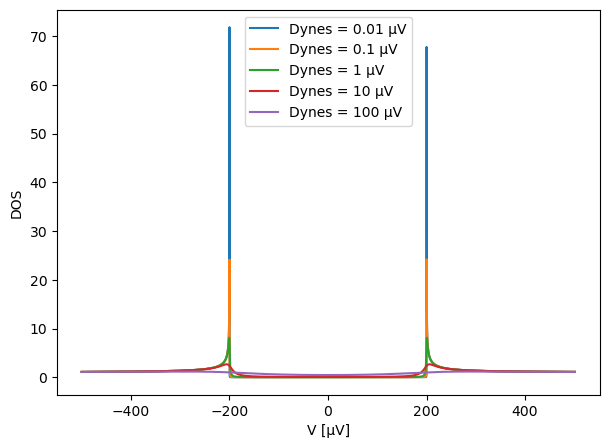

In [14]:
E = linspace(-500,501,9000)
delAl = 200
dynlist = [0.01, 0.1, 1, 10, 100]
for d in dynlist:
    plot(E,dynesDOS(E,d,delAl), label = f'Dynes = {d} µV')
legend()
xlabel('V [µV]')
ylabel('DOS')

### More Dynes DOS tests

Text(0, 0.5, 'DOS')

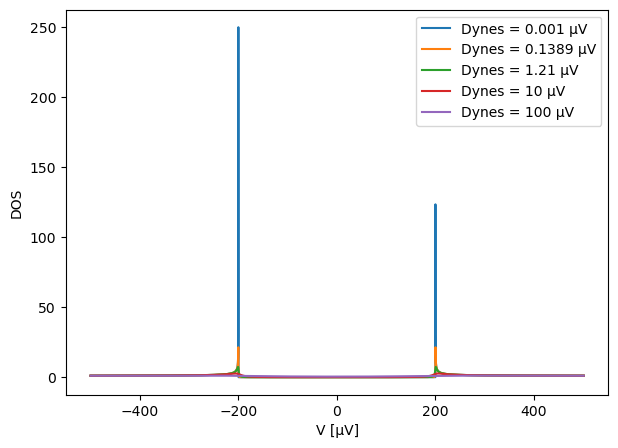

In [15]:
E = linspace(-500,501,9000)
delAl = 200
dynlist = [0.001, 0.1389, 1.21, 10, 100]
for d in dynlist:
    plot(E,dynesDOS(E,d,delAl), label = f'Dynes = {d} µV')
legend()
xlabel('V [µV]')
ylabel('DOS')

## Fermi-Dirac tests

Text(0.5, 0, 'E [uV]')

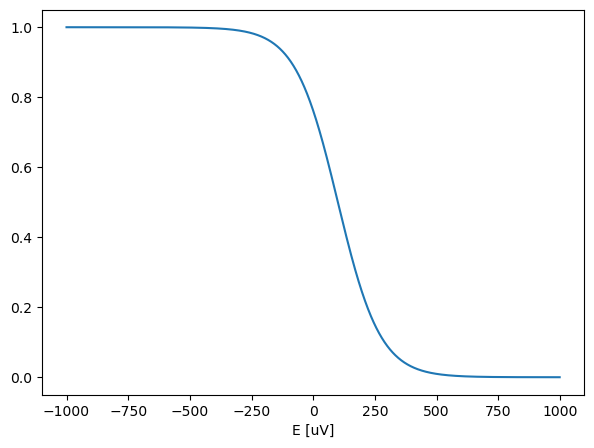

In [11]:
T=1
E = arange(-1000,1000, 1)
plot(E, fdd(E,T, 100))
xlabel('E [uV]')

## Semi-optimized SIS IV

CPU times: total: 156 ms
Wall time: 130 ms


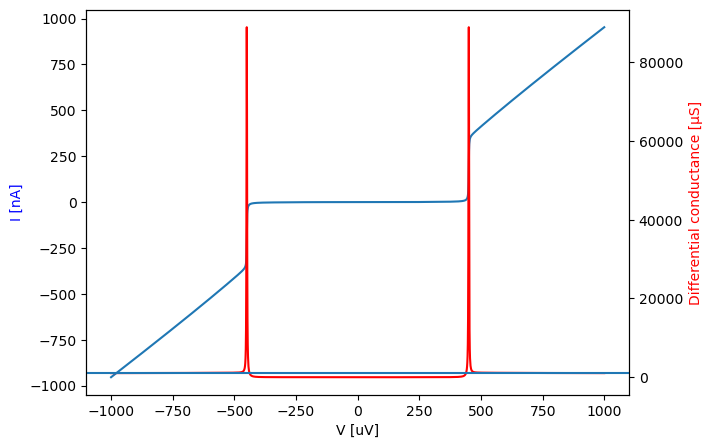

In [12]:
%%time
v = arange(-1000, 1000, 1)
deltaAl = 200
dynAl = 0.1
deltaGrAl = 250
dynGrAl = 1
T1 = 0.05
T2 = 0.05
R = 1e3
curr = fast_SIS_IV(v, deltaAl, dynAl, T1, deltaGrAl, dynGrAl, T2, R)
plot(v,curr*1e9)
xlabel('V [uV]')
ylabel('I [nA]', color = 'blue')
ax = gca()
ax1 = ax.twinx()
ax1.plot(v,gradient(curr*1e9, mean(diff(v)))*1e3, color = 'red')
ax1.set_ylabel('Differential conductance [µS]', color = 'red')
ax1.axhline(1e3)

## Semi-optimized SIN IV 

CPU times: total: 703 ms
Wall time: 690 ms


Text(0, 0.5, 'Differential conductance [µS]')

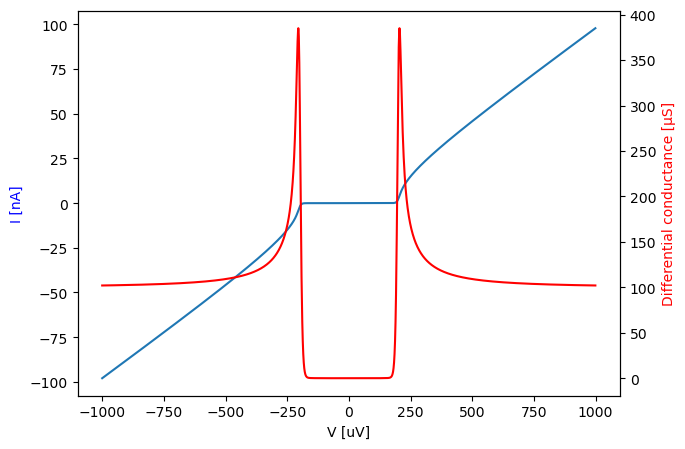

In [13]:
%%time
v = arange(-1000, 1000, 1)
deltaAl = 200
dynAl = 0.1
deltaGrAl = 250
dynGrAl = 1
T1 = 0.05
T2 = 0.05
R = 10e3
curr = fast_SIN_IV(v, deltaAl, dynAl, T1, T2, R)
plot(v,curr*1e9)
xlabel('V [uV]')
ylabel('I [nA]', color = 'blue')
ax = gca()
ax1 = ax.twinx()
ax1.plot(v,gradient(curr*1e9, mean(diff(v)))*1e3, color = 'red')
ax1.set_ylabel('Differential conductance [µS]', color = 'red')

# N <-> S tunneling

In [14]:
# Semi-optimized SIN IV
# Delta, dynes parameter, and voltage are in µV, temperatures are in K, resistance in Ohm
# Function returns current in A
# Voltage points need to be multiples of integration points (E), i.e. if v is spaced by 0.5 µV, de= 0.25, or 0.125, but not 0.4 or 0.2 
def SIN_rate(v,delta1, dyn1, T1, T2, R):
    de = 0.1
    maxv = math.ceil(max(abs(v))/de)*de
    maxe = max(2*maxv, 5*deltaAl)
    E = arange(-maxe-maxv, maxe+maxv, de)
    mask = logical_and(E > -maxe, E < maxe)
    offset = int_((v/de).reshape(len(v), 1))
    fermi2 = fdd(E, T2)
    dos1 = dynesDOS(E[mask], dyn1, delta1)
    fermi1 = fdd(E[mask], T1)
    curr = empty(len(v))
    gammans = empty(len(v))
    gammasn = empty(len(v))
    T = max(T1,T2)
    for i in range(len(v)):
        fermi2rolledp = roll(fermi2, offset[i])
        #fermi2rolledm = roll(fermi2, -offset[i])
        if v[i] < 0:
             maskv = logical_and(E[mask]>v[i]-20*c.k*T/c.e*1e6, E[mask]<+20*c.k*T/c.e*1e6)
        if v[i] >= 0:
             maskv = logical_and(E[mask]<v[i]+20*c.k*T/c.e*1e6, E[mask]>-20*c.k*T/c.e*1e6)
        gammans[i] = trapz(dos1*fermi2rolledp[mask]*(1-fermi1))*de
        #gammasn[i] = trapz(dos1*(1-fermi2rolledm[mask])*(fermi1))*de
    return gammans

20.181770646174055
10.54956192868189
5.157563609577814
CPU times: total: 1.38 s
Wall time: 1.4 s


Text(0.5, 1.0, 'Maisi Thesis, figure 2.3 (b)')

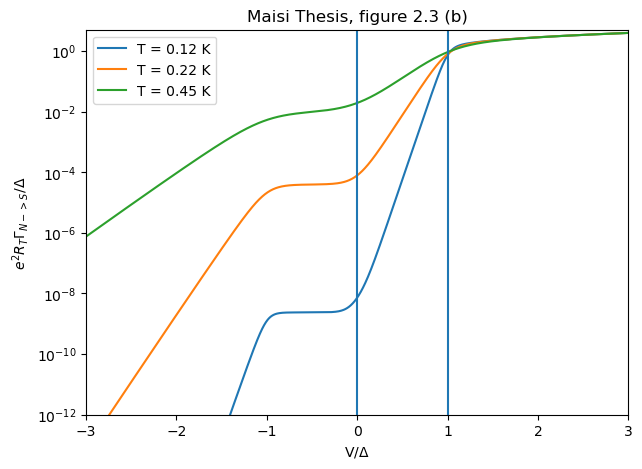

In [15]:
%%time
vsnrate = arange(-1000, 1000, 1)
deltaAl = 200
dynAl = 1e-5
Tlist = [0.115, 0.22, 0.45]
#Tlist = [0.115]
R = 100e3
for T in Tlist:
    print(deltaAl/toueV(T))
    nsnew = SIN_rate(vsnrate, deltaAl, dynAl, T, T, R)
    plot(vsnrate/deltaAl,nsnew/deltaAl, label = f'T = {T:1.2f} K')
legend()
xlim(-3,3)
semilogy()
ylim(1e-12,5)
xlabel('V/$\Delta$')
ylabel('$e^2R_T\Gamma_{N->S}/\Delta$')
axvline(0)
axvline(1)
title('Maisi Thesis, figure 2.3 (b)')

(-1.7, 1.7)

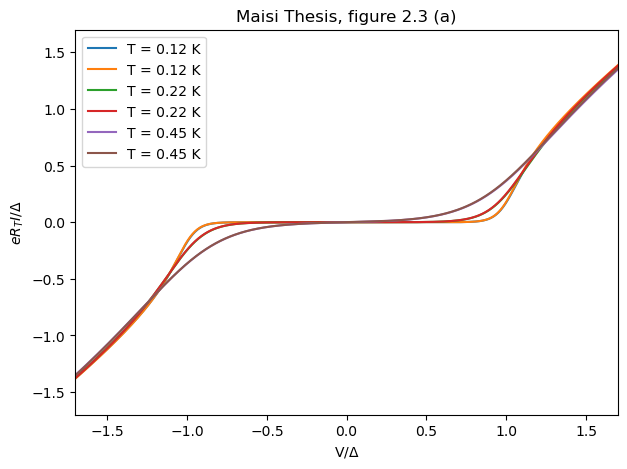

In [16]:
Tlist = [0.115, 0.22, 0.45]
R = 100e3
dynAl = 1e-2
for T in Tlist:
    siniv = fast_SIN_IV(v, deltaAl, dynAl, T, T, R)
    ns = SIN_rate(v, deltaAl, dynAl, T, T, R)
    plot(v/deltaAl, (siniv)/deltaAl*R*1e6, label = f'T = {T:1.2f} K')
    plot(v/deltaAl, (ns-flip(ns))/deltaAl, label = f'T = {T:1.2f} K')
legend()
xlabel('V/$\Delta$')
ylabel('$eR_TI/\Delta$')
title('Maisi Thesis, figure 2.3 (a)')
xlim(-1.7,1.7)
ylim(-1.7,1.7)

# SINIS master equation

- Ben Turek thesis sign convention

In [17]:
def RateSINIS(E, dE, dyn, delta, Tn, Ts):
    return  dynesDOS(E-dE, dyn, delta)*(1-fdd(E, Tn))*fdd(E-dE, Ts)

In [18]:
dyn = 1e-1
deltaAl = 200
Ts = 0.03
Tn = 0.03

tryparams = (dyn, deltaAl, Tn, Ts)

In [19]:
%%time
maxe = 5000
de = 0.25
vn = arange(-50, deltaAl+50, 1)
v = r_[arange(-1000, -50, 5), vn, arange(deltaAl+50, 1000, 5)]
ratearray = zeros_like(v, dtype = float)
E = arange(-maxe, maxe, de, dtype=float)
for i in range(len(v)):
    ratearray[i] = trapz(RateSINIS(E,v[i],*tryparams))*de
Rateinterp = UnivariateSpline(v, ratearray,k=1, s=0)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_16560\204757762.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)


CPU times: total: 1.97 s
Wall time: 1.98 s


(1e-15, 200.0)

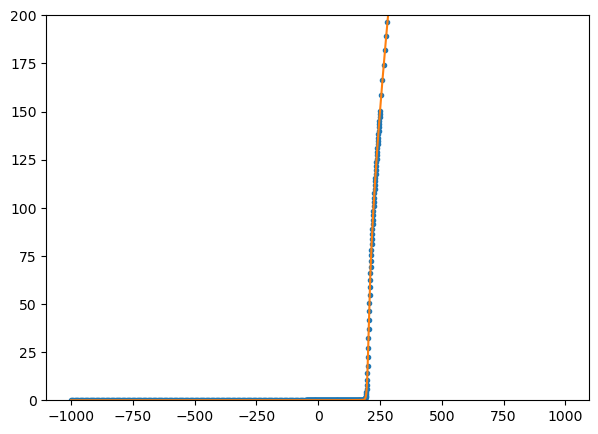

In [20]:
plot(v, ratearray, '.')
plot(v, Rateinterp(v))
#semilogy()
ylim(1e-15, 200)

In [21]:
def Gsn1(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2+(n-ng))+κ*v))*1e3/((κ)*R)
def Gns1(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2-(n-ng))-κ*v))*1e3/((κ)*R)
def Gsn2(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2+(n-ng))-κ*v))*1e3/((κ)*R)
def Gns2(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2-(n-ng))+κ*v))*1e3/((κ)*R)
def Gm(Ec, n, ng, v, κ1, κ2, R):
    return Gns1(Ec, n, ng, v, κ1, R) + Gns2(Ec, n, ng, v, κ2, R)
def Gp(Ec, n, ng, v, κ1, κ2, R):
    return Gsn1(Ec, n, ng, v, κ1, R) + Gsn2(Ec, n, ng, v, κ2, R)

In [22]:
%%time
Ec = 133
v = arange(-1500,1500,0.2)
n = arange(-5,6)
κ1 = 0.7
κ2 = 0.3
R = 700e3
ng=0
curr1junc = zeros((len(v), len(n)))
Gmatrix = zeros((len(v), len(n), len(n)))
for i, nrow in enumerate(n):
    for j, ncol in enumerate(n):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, v, κ1, κ2, R) - Gp(Ec, nrow, ng, v, κ1, κ2, R)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gm(Ec, ncol, ng, v, κ1, κ2, R)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gp(Ec, ncol, ng, v, κ1, κ2, R)
        else:
            Gmatrix[:,i,j] = 0
    curr1junc[:,i] = (Gsn1(Ec, nrow, ng, v, κ1, R)-Gns1(Ec, nrow, ng, v, κ1, R))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2, R)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2, R)
#Gmatmasked = Gmat[maskv,:,:]

CPU times: total: 15.6 ms
Wall time: 15.6 ms


(-1.0, 1.0)

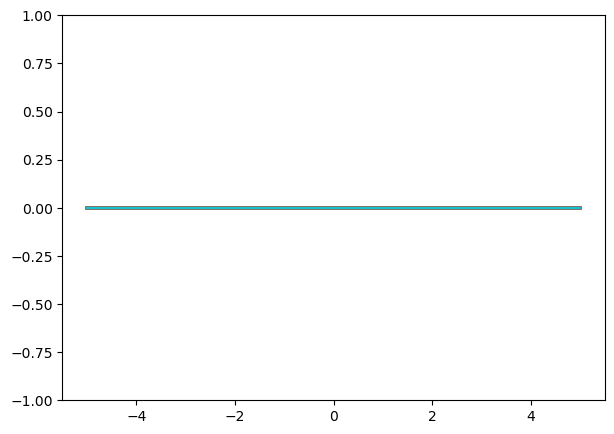

In [23]:
for i in range(len(v)):
    if i%100 ==0:
        plot(n,Gmatrix[i,:,:].sum(0))
ylim(-1,1)

In [24]:
Σ = zeros((11,11))
Σ[0] = ones(11)
svec = zeros(11)
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),11))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

Text(0, 0.5, 'Probability')

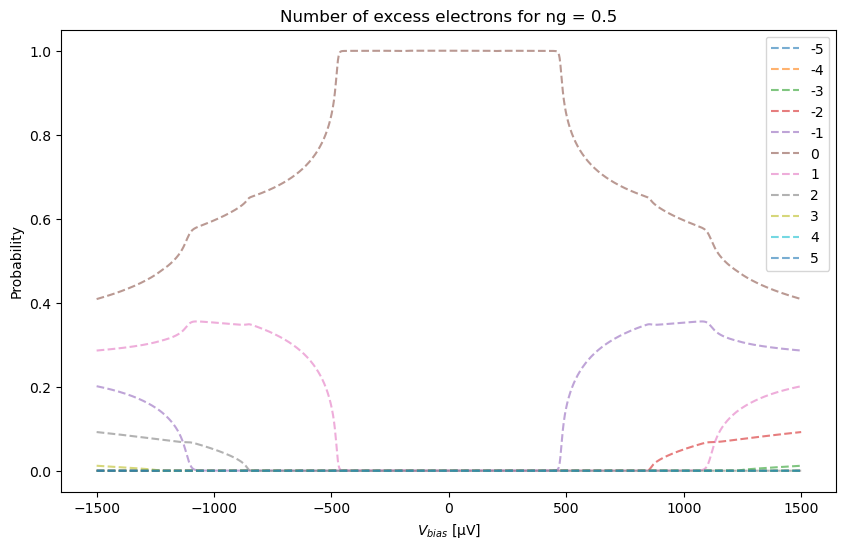

In [25]:
figure(figsize = (10,6))
for i in range(11):
    plot(v, probn[:,i], '--', alpha = 0.6,label = str(n[i]))
legend()
title('Number of excess electrons for ng = 0.5')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')

In [26]:
#curr1 = currfast
currfast = zeros_like(v)
for i in range(len(v)):
    currfast[i] = -sum(probn[i,:]*curr1junc[i,:])

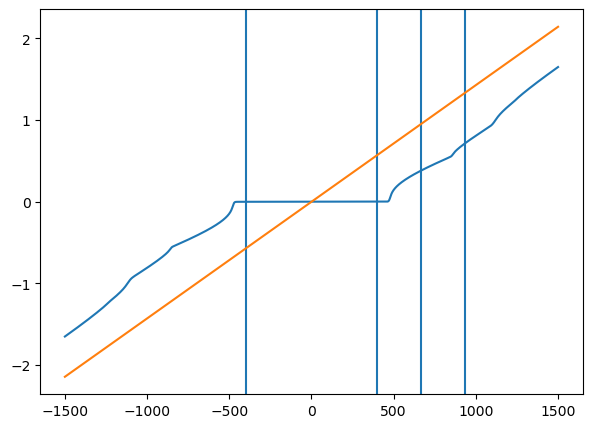

In [27]:
plot(v,currfast)
axvline(400)
axvline(-400)
axvline(400+266)
axvline(400+2*266)
plot(v, v*1e-6/R*1e9)

## ng dependence

In [28]:
v = arange(-1500,1500,1)
n = arange(-5,6)
κ1 = 0.7
κ2 = 0.3
R=700e3
nglist = arange(-1.6,1.61,0.01)
currfastng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(n)))
    Gmatrix = zeros((len(v), len(n), len(n)))
    for i, nrow in enumerate(n):
        for j, ncol in enumerate(n):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, v, κ1, κ2, R) - Gp(Ec, nrow, ng, v, κ1, κ2, R)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gm(Ec, ncol, ng, v, κ1, κ2, R)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gp(Ec, ncol, ng, v, κ1, κ2, R)
            else:
                Gmatrix[:,i,j] = 0
        curr1junc[:,i] = -(Gsn2(Ec, nrow, ng, v, κ2, R)-Gns2(Ec, nrow, ng, v, κ2, R))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2, R)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2, R)
    Σ = zeros((11,11))
    Σ[0] = ones(11)
    svec = zeros(11)
    ϵ = 1e-5
    svec[0] = ϵ
    probn = zeros((len(v),11))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        currfastng[k,i] = -sum(probn[i,:]*curr1junc[i,:])

Text(0, 0.5, 'Current [nA]')

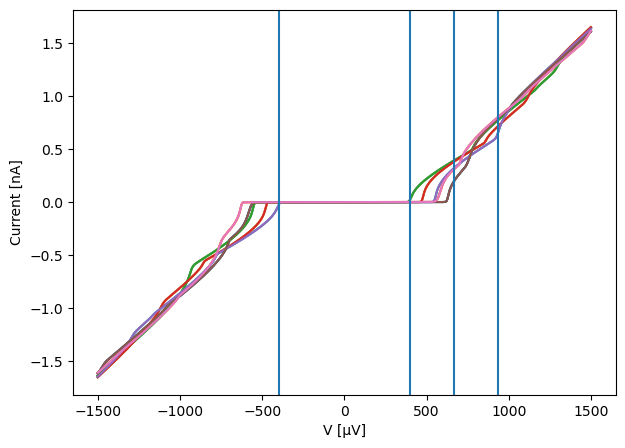

In [29]:
for i in range(len(nglist)):
    if i%20 == 0:
        plot(v, currfastng[i,:], label = str(nglist[i]))
axvline(400)
axvline(-400)
axvline(400+133*2)
axvline(400+133*4)
xlabel('V [µV]')
ylabel('Current [nA]')

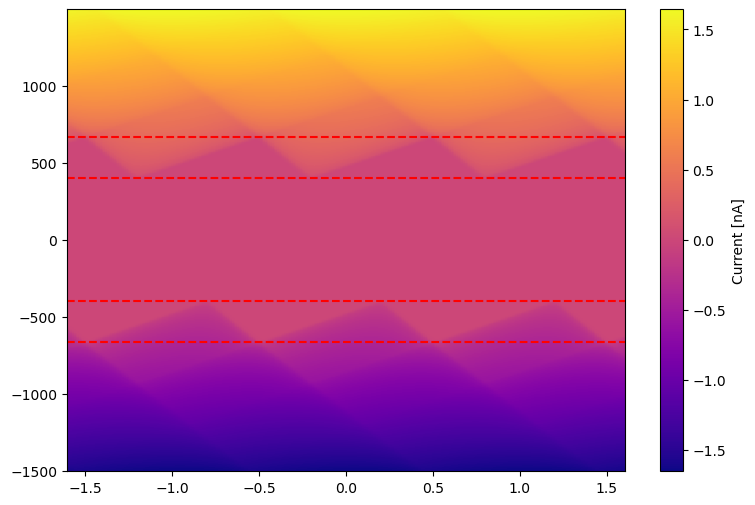

In [30]:
figure(figsize =(9,6))
pcolormesh(nglist,v[::5], currfastng[:,::5].T, cmap ='plasma')
colorbar(label = 'Current [nA]')
axhline(400, color ='red', ls = '--')
axhline(400+2*133, color ='red', ls = '--')
axhline(-400, color ='red', ls = '--')
axhline(-400-2*133, color ='red', ls = '--')

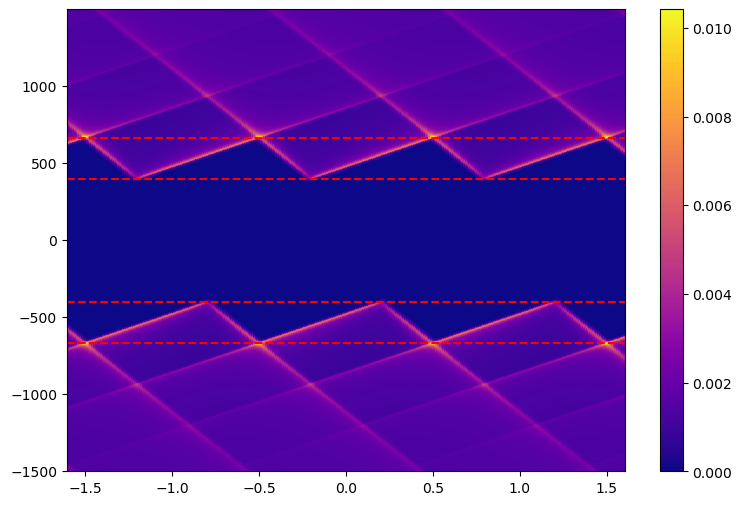

In [31]:
figure(figsize =(9,6))
conductancemap = gradient(currfastng, axis=1)[:,:]
pcolormesh(nglist,v, conductancemap.T, cmap ='plasma')
colorbar()
axhline(400, color ='red', ls = '--')
axhline(400+2*133, color ='red', ls = '--')
axhline(-400, color ='red', ls = '--')
axhline(-400-2*133, color ='red', ls = '--')

# SISIS master equation

In [32]:
dyn = 1e-2
deltaAl = 200
Ts = 0.05
Tn = 0.05
Ec = 133
SISISparams = (dyn, deltaAl, Tn, Ts)

In [33]:
%%time
maxe = 3200
de = 0.02
vn = arange(-20, 2*deltaAl-20, 2)
vn2 = arange(2*deltaAl-20, 2*deltaAl+20, 0.05)
v = r_[arange(-1600, -20, 5), vn, vn2, arange(2*deltaAl+20, 1600, 20)]
ratearr = zeros_like(v, dtype = float)
E = arange(-maxe, maxe, de, dtype=float)
for i in range(len(v)):
    ratearr[i] = trapz(RateSISIS(E,v[i],*SISISparams))*de
Rateinterp = UnivariateSpline(v, ratearr,k=1, s=0)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_16560\204757762.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)


CPU times: total: 1min 15s
Wall time: 1min 16s


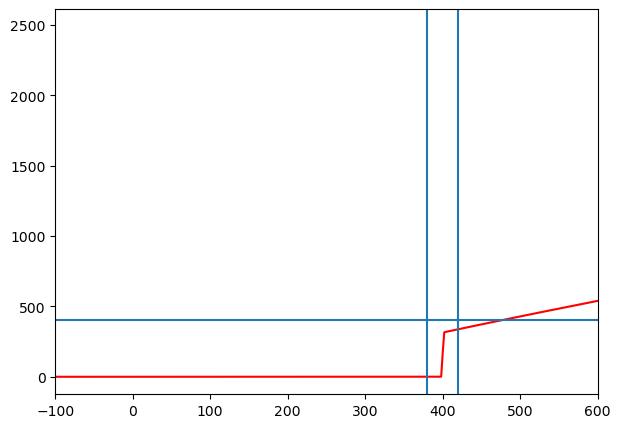

In [40]:
vint = arange(-2000,2500, 2)
#plot(v, ratearr, '.')
plot(vint, Rateinterp(vint), 'r')
#semilogy()
xlim(-100, 600)
#ylim(1e-12, 1e3)
#axvline(400)
axvline(400-20)
axvline(400+20)
axhline(4e2)
#axhline(1e-1)

In [41]:
v = arange(-1600,1600,0.5)
n = arange(-5,6)
κ1 = 0.6
κ2 = 0.4
R = 700e3
juncparams = (v, κ1, κ2, R)
Ec=120
n = arange(-5,6)
nglist = arange(-1.6,1.61,0.01)

In [42]:
%%time
Σ = zeros((11,11))
Σ[0] = ones(11)
svec = zeros(11)
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),11))
SISIScurrng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(n)))
    Gmatrix = zeros((len(v), len(n), len(n)))
    for i, nrow in enumerate(n):
        for j, ncol in enumerate(n):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, *juncparams) - Gp(Ec, nrow, ng, *juncparams)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gm(Ec, ncol, ng, *juncparams)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gp(Ec, ncol, ng, *juncparams)
            else:
                Gmatrix[:,i,j] = 0
        curr1junc[:,i] = (Gsn1(Ec, nrow, ng, v, κ1, R)-Gns1(Ec, nrow, ng, v, κ1, R))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, *juncparams)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, *juncparams)
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        SISIScurrng[k, i] = -sum(probn[i,:]*curr1junc[i,:])

CPU times: total: 22.4 s
Wall time: 22.6 s


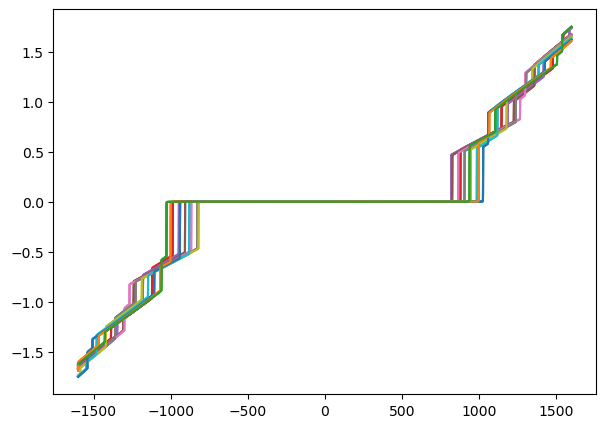

In [44]:
for i in range(len(nglist)):
    if i%10 == 0:
        plot(v, SISIScurrng[i,:], label = str(nglist[i]))
#ylim(-450,450)

(-1.4, 1.2)

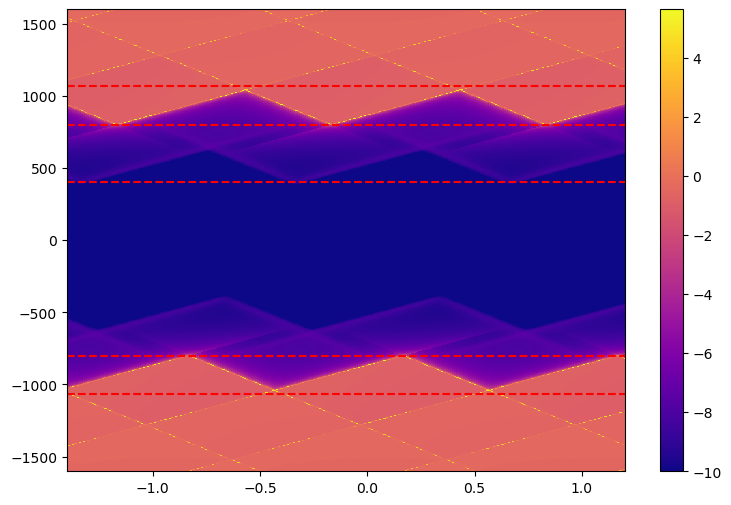

In [45]:
figure(figsize =(9,6))
conductancemap = gradient(SISIScurrng, axis=1)[:,:]
pcolormesh(nglist,v[::5], log(conductancemap[:,::5].T*1000), vmin = -10, cmap ='plasma')
colorbar()
axhline(400, color ='red', ls = '--')
axhline(800, color ='red', ls = '--')
axhline(800+2*133, color ='red', ls = '--')
axhline(-800, color ='red', ls = '--')
axhline(-800-2*133, color ='red', ls = '--')
xlim(-1.4,1.2)

(-1.4, 1.2)

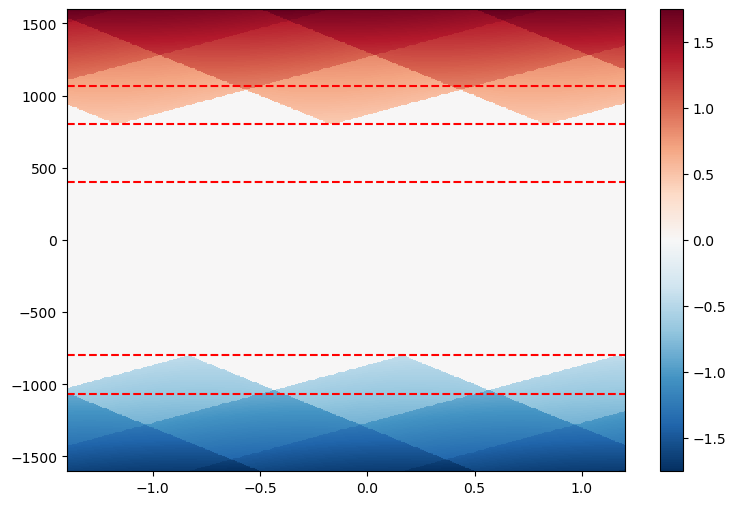

In [46]:
figure(figsize =(9,6))
pcolormesh(nglist,v[::10], gf(SISIScurrng[:,::10], (0.1,0.1)).T, cmap ='RdBu_r')
colorbar()
axhline(400, color ='red', ls = '--')
axhline(800, color ='red', ls = '--')
axhline(800+2*133, color ='red', ls = '--')
axhline(-800, color ='red', ls = '--')
axhline(-800-2*133, color ='red', ls = '--')
xlim(-1.4,1.2)

(900.0, 1000.0)

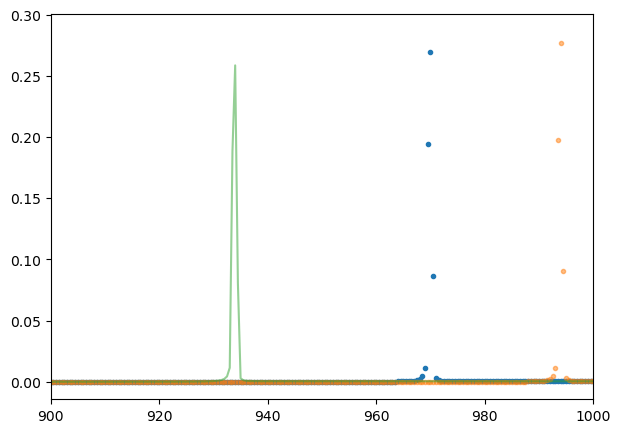

In [47]:
plot(v, conductancemap[15], '.')
plot(v, conductancemap[11], '.', alpha = 0.5)
plot(v, conductancemap[121], alpha = 0.5)
xlim(900,1000)

## Conductance maps

In [2243]:
def funSISIS(E, dE, dyn, delta, Tn, Ts):
    return  dynesDOS(E-dE, dyn, delta)*dynesDOS(E, dyn, delta)*(1-fdd(E, Tn))*fdd(E-dE, Ts)

def dynesDEVspl(E, dyn, delta):
    return UnivariateSpline(E, gradient(dynesDOS(E,dyn,delAl),E), k=1, s=0)

def fdddev(E, T, mu=0):
    return -exp((E-mu)*c.e*1e-6/c.k/T)/(c.k*T/c.e*1e6*(1+exp((E-mu)*c.e*1e-6/c.k/T))**2)

def fdddevspl(E, T, mu=0):
    return UnivariateSpline(E, gradient(fdd(E,T),E), k=1, s=0)
    
    
#def funSISIScond(E, dE, dyn, delta, Tn, Ts):
    #return dynesDOS(E,dyn,delta)*(1-fdd(E, Tn))*(fdd(E-dE,Ts)*-dynesDEVspl(E, dyn, delta)(E-dE)+fdddev(E-dE, Ts)*dynesDOS(E-dE, dyn, delta))
    
#def funSISIScond(E, dE, dyn, delta, Tn, Ts):
    #return dynesDOS(E,dyn,delta)*(1-fdd(E, Tn))*(fdd(E-dE,Ts)*-dynesDEVspl(E, dyn, delta)(E-dE)+gradient(fdd(E-dE, 0.05),E)*dynesDOS(E-dE, dyn, delta))
    
def funSISIScond(E, dE, dyn, delta, Tn, Ts):
    return dynesDOS(E,dyn,delta)*(1-fdd(E, Tn))*(fdd(E-dE,Ts)*-dynesDEVspl(E, dyn, delta)(E-dE)+fdddevspl(E,T)(E-dE)*dynesDOS(E-dE, dyn, delta))

In [2269]:
dyn = 1e-1
deltaAl = 200
Ts = 0.25
Tn = 0.25
Ec = 133
tryparams = (dyn, deltaAl, Tn, Ts)

In [2303]:
%%time
maxe = 3200
de = 0.0125
v = arange(-1600,1600,1)
cuckotrapzcond = zeros_like(v, dtype = float64)
E = arange(-maxe, maxe, de, dtype=float64)
for i in range(len(v)):
    cuckotrapzcond[i] = trapz(funSISIScond(E,v[i],*tryparams))*de

CPU times: total: 12min 56s
Wall time: 12min 59s


In [2304]:
#Rateinterp = UnivariateSpline(v, cuckotrapz/200,k=1, s=0)
condinterp = UnivariateSpline(v, cuckotrapzcond,k=1, s=0)

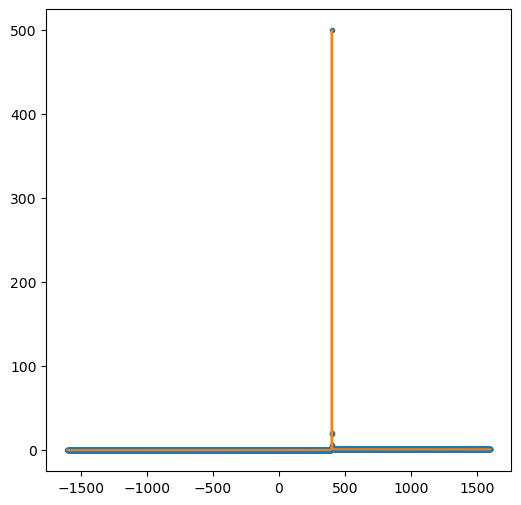

In [2306]:
plot(v, cuckotrapzcond, '.')
plot(v, condinterp(v))
#plot(v, Rateinterp(v))
#semilogy()
#ylim(-0.5, 1)

In [2307]:
Ec = 133
def Gsn1cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2+(n-ng))+κ*v))
def Gns1cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2-(n-ng))-κ*v))
def Gsn2cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2+(n-ng))-κ*v))
def Gns2cond(Ec, n, ng, v, κ):
    return condinterp(-(2*Ec*(1/2-(n-ng))+κ*v))
def Gmcond(Ec, n, ng, v, κ1, κ2):
    return Gns1cond(Ec, n, ng, v, κ1) + Gns2cond(Ec, n, ng, v, κ2)
def Gpcond(Ec, n, ng, v, κ1, κ2):
    return Gsn1cond(Ec, n, ng, v, κ1) + Gsn2cond(Ec, n, ng, v, κ2)

In [2313]:
v = arange(0,1900,1)
n = arange(-5,6)
κ1 = 0.5
κ2 = 0.5
nglist = arange(-1.6,1.605,0.005)
currfastng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(n)))
    Gmatrix = zeros((len(v), len(n), len(n)))
    for i, nrow in enumerate(n):
        for j, ncol in enumerate(n):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gmcond(Ec, nrow, ng, v, κ1, κ2) - Gpcond(Ec, nrow, ng, v, κ1, κ2)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gmcond(Ec, ncol, ng, v, κ1, κ2)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gpcond(Ec, ncol, ng, v, κ1, κ2)
            else:
                Gmatrix[:,i,j] = 0
        curr1junc[:,i] = (Gsn1cond(Ec, nrow, ng, v, κ1)-Gns1cond(Ec, nrow, ng, v, κ1))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2)
    Σ = zeros((11,11))
    Σ[0] = ones(11)
    svec = zeros(11)
    ϵ = 1e-5
    svec[0] = ϵ
    probn = zeros((len(v),11))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        currfastng[k,i] = -sum(probn[i,:]*curr1junc[i,:])

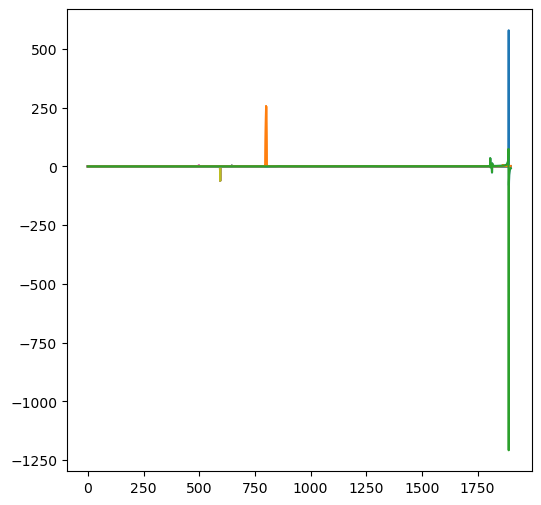

In [2314]:
for i in range(len(nglist)):
    if i%20 == 0:
        plot(v, currfastng[i,:], label = str(nglist[i]))
#axvline(400)
#axvline(-400)
#axvline(400+133*2)
#axvline(400+133*4)
#xlim(-600,600)
#ylim(-5,5)

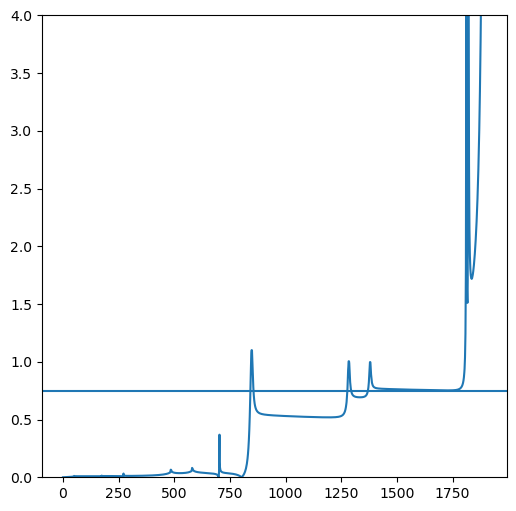

In [2320]:
plot(v, abs(currfastng[2]))
ylim(0,4)
axhline(0.75)

(-1.4, 1.2)

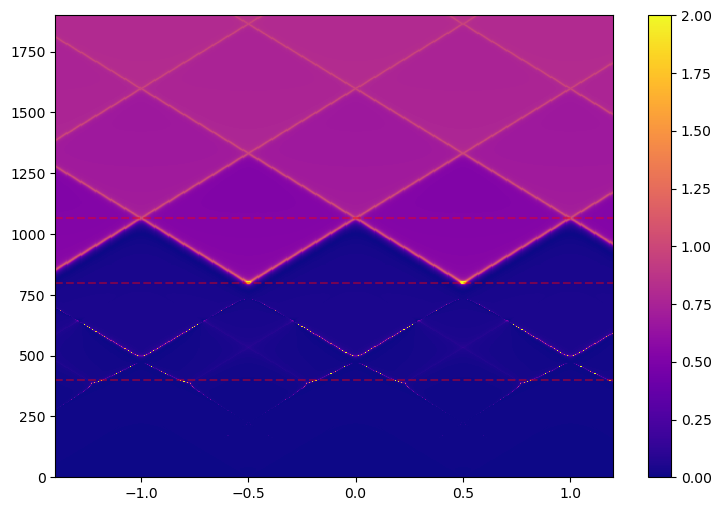

In [2316]:
figure(figsize =(9,6))
#conductancemap = gradient(currfastng, axis=1)[:,:]
pcolormesh(nglist,v, abs(currfastng).T, vmin = 0, vmax = 2, cmap ='plasma')
colorbar()
axhline(400, color ='red', ls = '--', alpha = 0.4)
axhline(800, color ='red', ls = '--', alpha = 0.4)
axhline(800+2*133, color ='red', ls = '--', alpha = 0.4)
#axhline(-800, color ='red', ls = '--', alpha = 0.4)
#axhline(-800-2*133, color ='red', ls = '--', alpha = 0.4)
xlim(-1.4,1.2)

(0.0, 3.0)

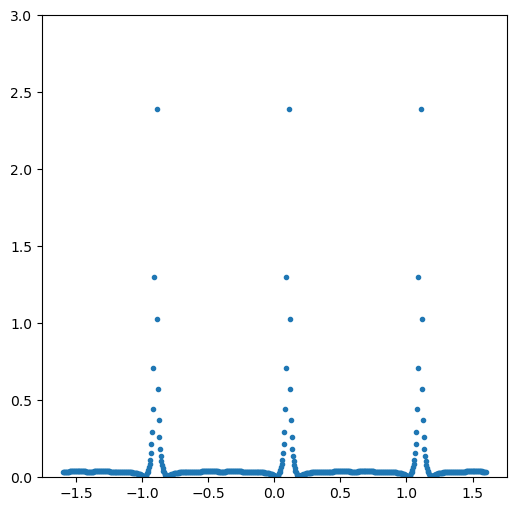

In [2312]:
plot(nglist, abs(currfastng[:,800]), '.')
#plot(v, abs(currfastng[14]), '.', alpha = 0.5)
ylim(0,3)
#axhline(0.7)
#xlim(900,1000)

# Photon-Assisted tunneling

- Computing [$|\omega_{n,l}(\lambda)|^2$ ](https://arxiv.org/abs/1807.02364)

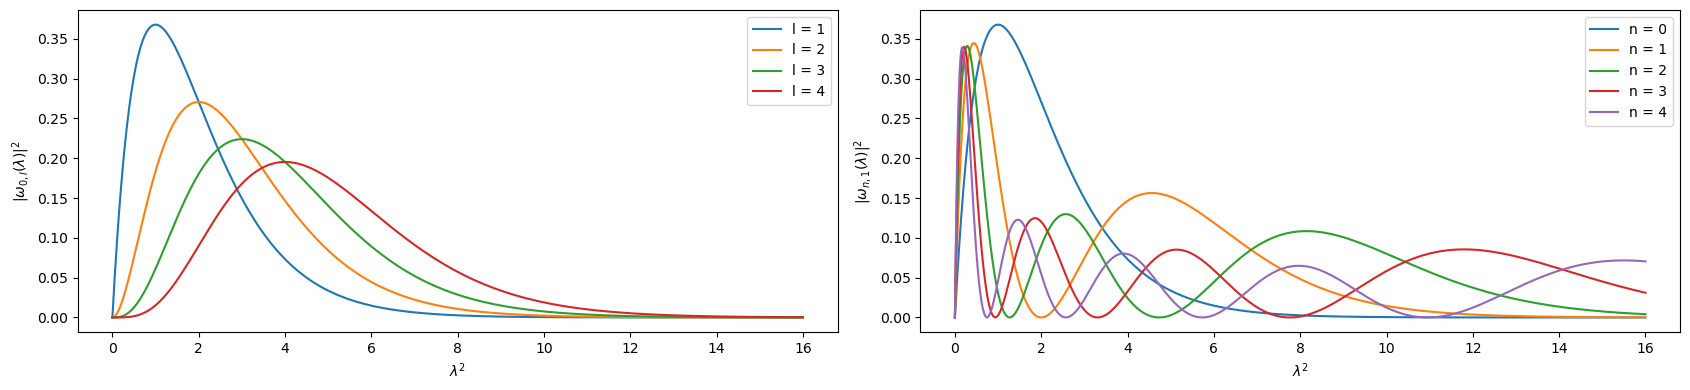

In [48]:
fig, ax = subplots(1, 2, figsize = (17,4))
lbda = linspace(0,4,200)
for i in range(1,5):
    ax[0].plot(lbda**2, alphanl(0,i,lbda), label = f'l = {i}')
#ax[0].plot(lbda**2, exp(-lbda**2), '--')
ax[0].set_xlabel('$\lambda ^2$')
ax[0].set_ylabel('$|\omega_{0,l}(\lambda)|^2$')
ax[0].legend()
for i in range(5):
    ax[1].plot(lbda**2, alphanl(i,1,lbda), label = f'n = {i}')
ax[1].set_xlabel('$\lambda ^2$')
ax[1].set_ylabel('$|\omega_{n,1}(\lambda)|^2$')
ax[1].legend()
tight_layout()

#### Array of Franck-Condon coefficients

In [49]:
def generateLaguerrearray(nl, λ):
    Laguerrearr = zeros((nl, nl))
    for i in range(nl):
        for j in range(nl):
            Laguerrearr[i,j] = alphanl(i,j,λ)
    return Laguerrearr

### Tunneling current 

In [50]:
v = arange(0,3500,0.5)
n = arange(-5,6)
κ1 = 0.5
κ2 = 0.5
R=700e3
Ec=80
ng=0.5
curr1junc = zeros((len(v), len(n)))
Gmatrix = zeros((len(v), len(n), len(n)))
for i, nrow in enumerate(n):
    for j, ncol in enumerate(n):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gm(Ec, nrow, ng, v, κ1, κ2, R) - Gp(Ec, nrow, ng, v, κ1, κ2, R)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gm(Ec, ncol, ng, v, κ1, κ2, R)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gp(Ec, ncol, ng, v, κ1, κ2, R)
        else:
            Gmatrix[:,i,j] = 0
    curr1junc[:,i] = (Gsn1(Ec, nrow, ng, v, κ1, R)-Gns1(Ec, nrow, ng, v, κ1, R))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gm(Ec, n[0], ng, v, κ1, κ2, R)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gp(Ec, n[-1], ng, v, κ1, κ2, R)
#Gmatmasked = Gmat[maskv,:,:]

In [51]:
Σ = zeros((11,11))
Σ[0] = ones(11)
svec = zeros(11)
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),11))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

Text(0, 0.5, 'Probability')

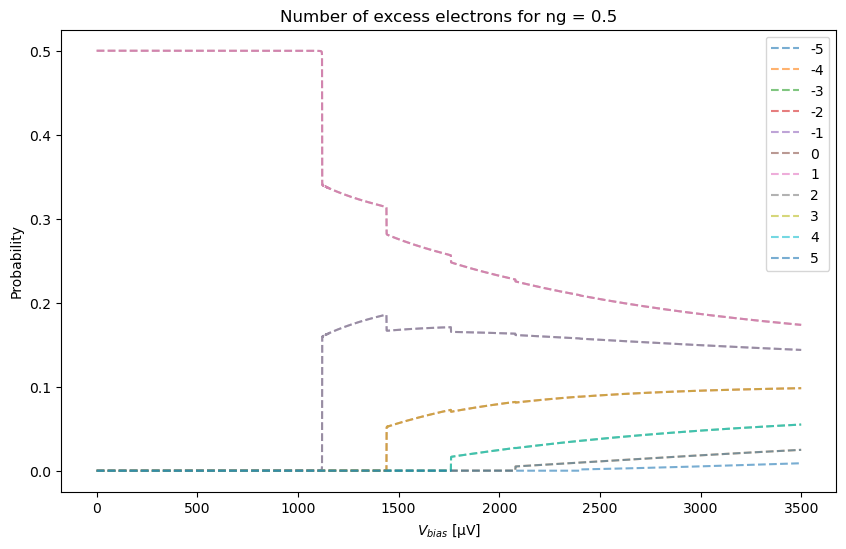

In [52]:
figure(figsize = (10,6))
for i in range(11):
    plot(v, probn[:,i], '--', alpha = 0.6,label = str(n[i]))
legend()
title('Number of excess electrons for ng = 0.5')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')

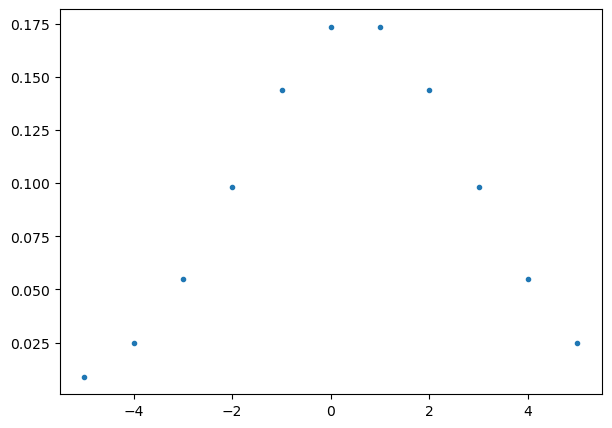

In [53]:
plot(n, probn[-1,:], '.')

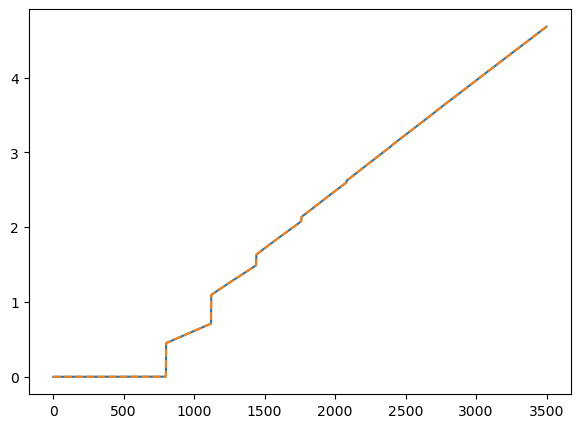

In [54]:
currzerona = zeros_like(v)
for i in range(len(v)):
    currzerona[i] = -sum(probn[i,:]*curr1junc[i,:])
plot(v, currzerona)
czinterp = UnivariateSpline(v, currzerona,k=1, s=0)
plot(v, czinterp(v), '--')

### Photon-assisted current for arbitrary $\lambda$

(500.0, 1200.0)

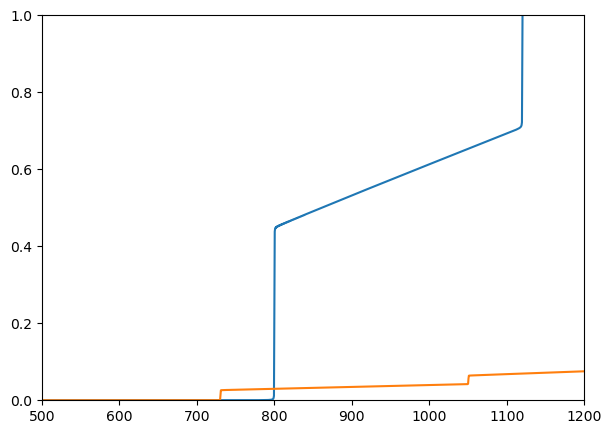

In [55]:
Rk = 25812
Zc = 50
λ = 0.25
f = 16.811e9
v = arange(0,3500,0.5)
plot(v, currzerona)
plot(v, czinterp(v+c.h*f/c.e*1e6)*alphanl(0,1,λ))
#xlim(700,1800)
#axvline(800+266)
ylim(0,1)
xlim(500,1200)

In [56]:
nph = arange(1,10)
phcurr = zeros((len(nph), len(v)))
for kk, np in enumerate(nph):
        for i in range(1,np+1):
             phcurr[kk,:] = phcurr[kk,:] + czinterp(v+i*c.h*f/c.e*1e6)*alphanl(np-i,i,λ)

Text(0.5, 0, 'V [µV]')

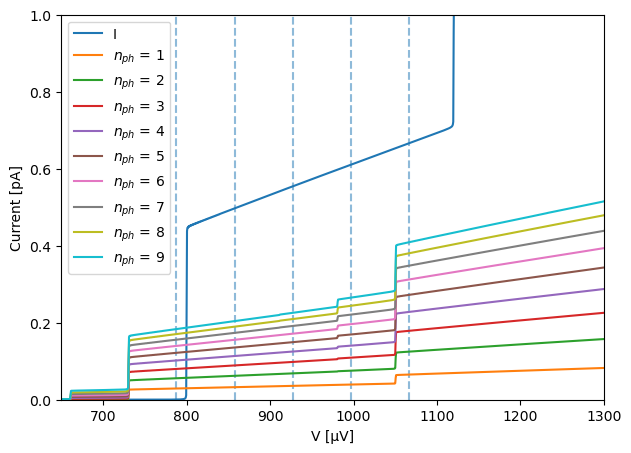

In [57]:
plot(v, currzerona, label = 'I')
axvline(800+266, alpha = 0.5, ls = '--')
axvline(800+266-c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-2*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-3*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-4*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
for kk in range(len(nph)):
    plot(v, phcurr[kk], label = '$n_{ph}$ = '+str(nph[kk]))
xlim(650,1300)
ylim(0,1)
legend()
ylabel('Current [pA]')
xlabel('V [µV]')

#### Coulomb blockade

In [58]:
nph = r_[5]
phcurrb = zeros((len(nph), len(v)))
for kk, np in enumerate(nph):
        for i in range(np+1):
             phcurrb[kk,:] = phcurrb[kk,:] + czinterp(v-i*c.h*f/c.e*1e6)*alphanl(1,i,λ)

Text(0.5, 0, 'V [µV]')

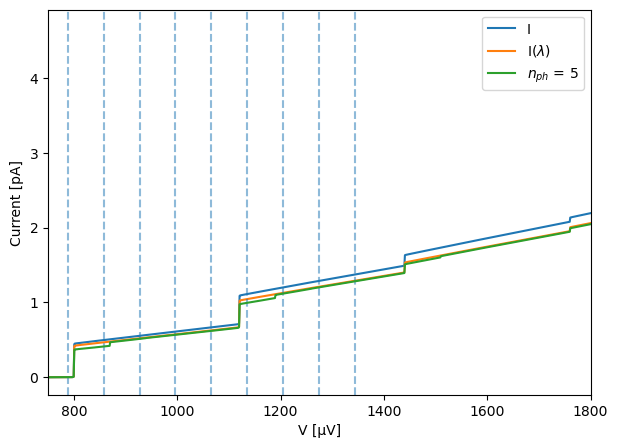

In [59]:
plot(v, currzerona, label = 'I')
plot(v, currzerona*exp(-λ**2), label = 'I($\lambda$)')
axvline(800+266, alpha = 0.5, ls = '--')
axvline(800+266+c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266+2*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266+3*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266+4*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-2*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-3*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
axvline(800+266-4*c.h*f/c.e*1e6, alpha = 0.5, ls = '--')
for kk in range(len(nph)):
    plot(v, (phcurrb[kk]), label = '$n_{ph}$ = '+str(nph[kk]))
xlim(750,1800)
#ylim(0,0.1)
legend()
ylabel('Current [pA]')
xlabel('V [µV]')

# Master equation including the state of the resonator

### For an empty resonator

In [60]:
ntrunc = 5
λ = 0.2
phtry = zeros(len(v))
for i in range(ntrunc+1):
    phtry = phtry + czinterp(v-i*c.h*f/c.e*1e6)*alphanl(1,i,λ)

In [411]:
def blockedGm(v, ntrunc):
    phtry = zeros_like(v)
    for i in range(ntrunc+1):
        phtry = phtry + czinterp(v-i*c.h*f/c.e*1e6)*alphanl(1,i,λ)
    return phtry

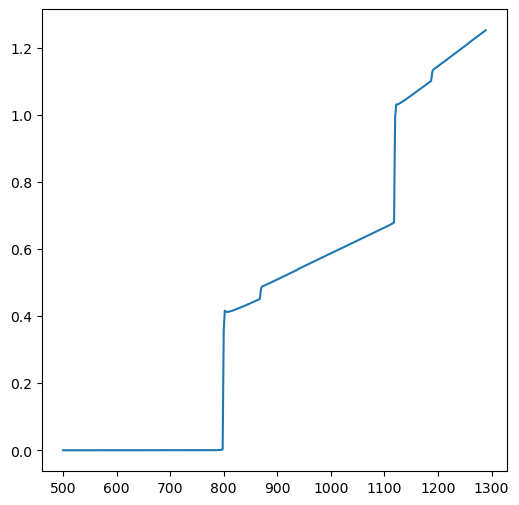

In [296]:
vv = arange(500,1290,1)
plot(vv, blockedGm(vv,5))

In [61]:
def Gsn1phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v+nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gns1phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gsn2phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gns2phb(Ec, ne, nph, nphem, ng, v, κ, R, f, λ):
    return Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v+nphem*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphem,λ)
def Gmphb(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for i in range(ntrunc + 1):
        g += Gns1phb(Ec, ne, nph, i, ng, v, κ1, R, f, λ) + Gns2phb(Ec, ne, nph, i, ng, v, κ2, R, f, λ)
    return g
def Gpphb(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for i in range(ntrunc + 1):
        g += Gsn1phb(Ec, ne, nph, i, ng, v, κ1, R, f, λ) + Gsn2phb(Ec, ne, nph, i, ng, v, κ2, R, f, λ)
    return g

In [62]:
def Gsn1(Ec, n, ng, v, κ, R):
    return Rateinterp(-(2*Ec*(1/2+(n-ng))+κ*v))*1e3/((κ)*R)

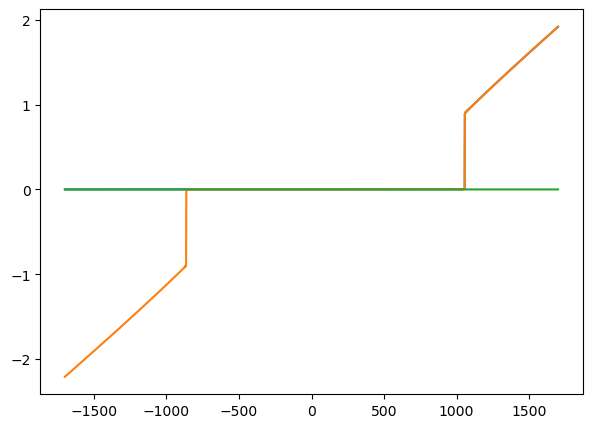

In [63]:
λ = 0.003
v = arange(-1700,1700,0.5)
plot(v, Gns1(Ec, 0, 0.3, v, κ1, R))
plot(v, Gns1phb(Ec, 0, 0, 0, 0.3, v, κ1, R, f, λ)-Gsn1phb(Ec, 0, 0, 0, 0.3, v, κ1, R, f, λ))
plot(v, Gns1phb(Ec, 0, 0, 1, 0.3, v, κ1, R, f, λ)-Gsn1phb(Ec, 0, 0, 1, 0.3, v, κ1, R, f, λ))

In [64]:
λ = 0.7
f = 14.811e9
v = arange(-1700,1700,1, float)
ne = arange(-3,4)
κ1 = 0.5
κ2 = 0.5
R=700e3
nph = 0
ntrunc = 5
Ec=133
ng=0.4
curr1junc = zeros((len(v), len(ne)))
Gmatrix = zeros((len(v), len(ne), len(ne)))
for i, nrow in enumerate(ne):
    for j, ncol in enumerate(ne):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gmphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ) - Gpphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gmphb(Ec, ncol,nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gpphb(Ec, ncol, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        else:
            Gmatrix[:,i,j] = 0
    for kk in range(ntrunc):
        curr1junc[:,i] += (Gsn1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ)-Gns1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gmphb(Ec, ne[0], nph,ntrunc, ng, v, κ1, κ2, R, f, λ)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gpphb(Ec, ne[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
#Gmatmasked = Gmat[maskv,:,:]

In [65]:
Σ = zeros((len(ne),len(ne)))
Σ[0] = ones(len(ne))
svec = zeros(len(ne))
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),len(ne)))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

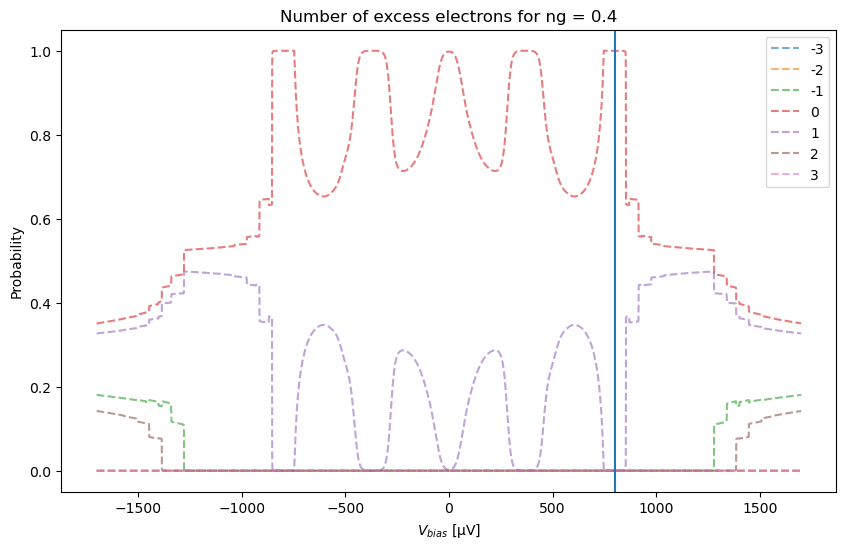

In [66]:
figure(figsize = (10,6))
for i in range(len(ne)):
    plot(v, probn[:,i], '--', alpha = 0.6,label = str(ne[i]))
legend()
title(f'Number of excess electrons for ng = {ng}')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')
axvline(800)

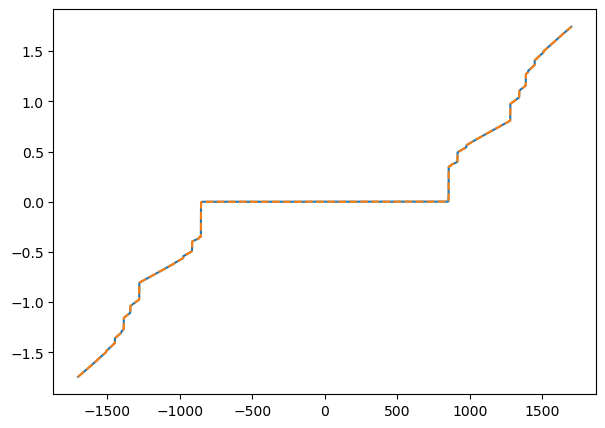

In [67]:
currempty = zeros_like(v)
for i in range(len(v)):
    currempty[i] = -sum(probn[i,:]*curr1junc[i,:])
plot(v, currempty)
czinterp = UnivariateSpline(v, currempty,k=1, s=0)
plot(v, czinterp(v), '--')

### ng dependence

In [68]:
λ = 0.9
f = 14.811e9
v = arange(0,1700,0.5)
ne = arange(-7,8)
κ1 = 0.55
κ2 = 0.45
R=700e3
nph = 0
ntrunc = 5
Ec=80
nglist = arange(-1.6,1.61,0.005)
currblng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(ne)))
    Gmatrix = zeros((len(v), len(ne), len(ne)))
    for i, nrow in enumerate(ne):
        for j, ncol in enumerate(ne):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gmphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ) - Gpphb(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gmphb(Ec, ncol,nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gpphb(Ec, ncol, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            else:
                Gmatrix[:,i,j] = 0
        for kk in range(ntrunc):
            curr1junc[:,i] += (Gsn1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ)-Gns1phb(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gmphb(Ec, ne[0], nph,ntrunc, ng, v, κ1, κ2, R, f, λ)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gpphb(Ec, ne[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
    Σ = zeros((len(ne),len(ne)))
    Σ[0] = ones(len(ne))
    svec = zeros(len(ne))
    ϵ = 1e-5
    svec[0] = ϵ
    probn = zeros((len(v),len(ne)))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        currblng[k,i] = -sum(probn[i,:]*curr1junc[i,:])

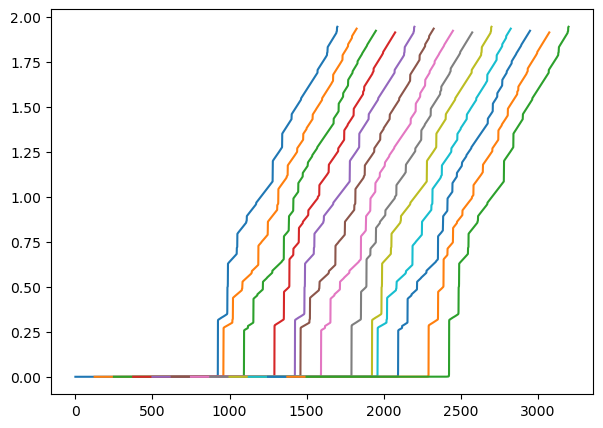

In [69]:
for i in range(len(nglist)):
    if i%50 == 0:
        plot(v+i*2.5, currblng[i,:], label = str(nglist[i]))
#plot(v, v*1e-6/R*0.7*1e9-0.4)

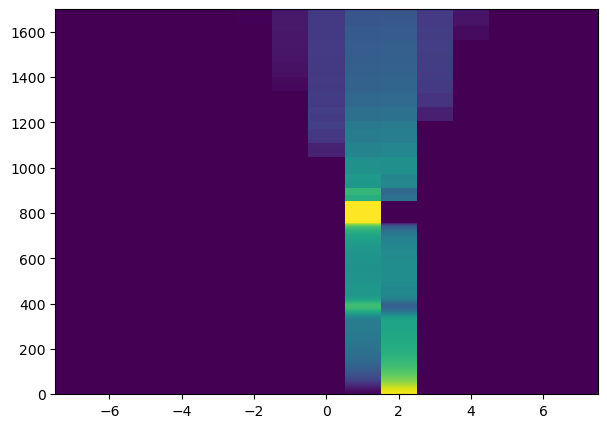

In [70]:
pcolormesh(ne, v, probn)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_16560\261075102.py:1: RuntimeWarning: invalid value encountered in log10
  pcolormesh(nglist, v, log10(gradient((currblng.T)*1e3, axis = 0)), cmap = 'Blues')


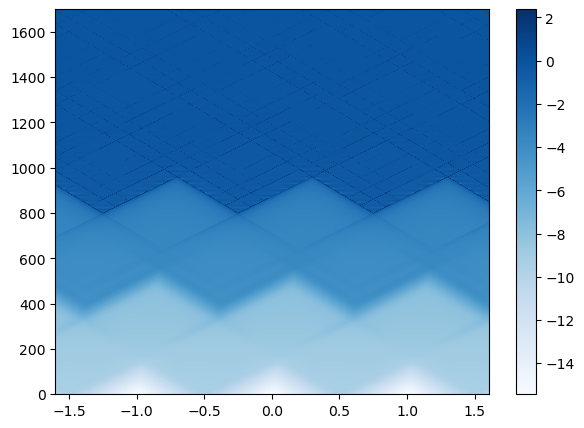

In [71]:
pcolormesh(nglist, v, log10(gradient((currblng.T)*1e3, axis = 0)), cmap = 'Blues')
colorbar()
#ylim(750, 1000)

## Arbitrary resonator fock state

In [72]:
#czinterp(v+i*c.h*f/c.e*1e6)*alphanl(np-i,i,λ)

In [435]:
def Gsn1ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gns1ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gsn2ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gns2ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate
def Gmph(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f, λ):
    g = Gns1ph(Ec, ne, nph, nphend, ng, v, κ1, R, f, λ) + Gns2ph(Ec, ne, nph, nphend, ng, v, κ2, R, f, λ)
    return g
def Gpph(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f, λ):
    g = Gsn1ph(Ec, ne, nph, nphend, ng, v, κ1, R, f, λ) + Gsn2ph(Ec, ne, nph, nphend, ng, v, κ2, R, f, λ)
    return g

In [438]:
ntrunc = 5
nph = 1
f = 4e9
v = arange(-1200,1700, 2, float)
Gmsum  = zeros_like(v)
Gpsum  = zeros_like(v)
for i in range(ntrunc + 1):
    Gmsum += Gmph(Ec, 0, nph, i, 0.5, v, 0.5, 0.5, R, f, 0.8)
    Gpsum += Gpph(Ec, 0, nph, i, 0.5, v, 0.5, 0.5, R, f, 0.8)

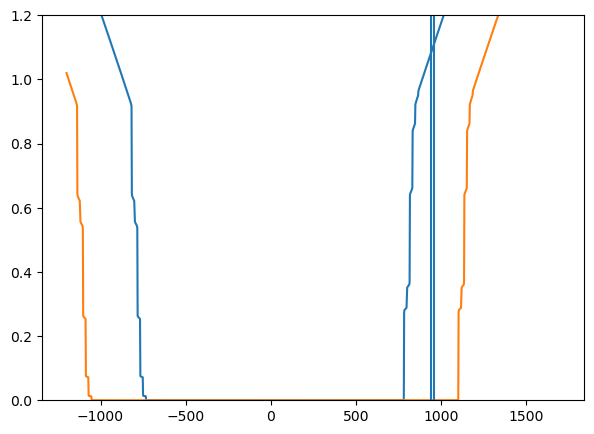

In [439]:
plot(v, Gpsum)
plot(v, Gmsum)
#xlim(700, 1500)
ylim(0,1.2)
axvline(4*200 + 2*Ec - 1*c.h*f/c.e*1e6)
axvline(4*200 + 2*Ec)
#axvline(4*200 + 0*Ec)

In [440]:
def Gpphsum(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gpph(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f, λ)
    return g
def Gmphsum(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gmph(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f, λ)
    return g

In [441]:
λ = 0.1
f = 4.811e9
v = arange(-1700,1700,1, float)
ne = arange(-7,8)
κ1 = 0.5
κ2 = 0.5
R=700e3
nph = 2
ntrunc = nph+5
Ec=203
ng=0.25
curr1junc = zeros((len(v), len(ne)))
Gmatrix = zeros((len(v), len(ne), len(ne)))
for i, nrow in enumerate(ne):
    for j, ncol in enumerate(ne):
        if nrow == ncol:
            Gmatrix[:, i, j] = - Gmphsum(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ) - Gpphsum(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == 1:
            Gmatrix[:, i, j] = Gmphsum(Ec, ncol,nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        elif j - i == - 1:
            Gmatrix[:, i, j] = Gpphsum(Ec, ncol, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
        else:
            Gmatrix[:,i,j] = 0
    for kk in range(ntrunc+1):
        curr1junc[:,i] += (Gsn1ph(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ)-Gns1ph(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ))
Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gmphsum(Ec, ne[0], nph,ntrunc, ng, v, κ1, κ2, R, f, λ)
Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gpphsum(Ec, ne[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
#Gmatmasked = Gmat[maskv,:,:]

In [442]:
Σ = zeros((len(ne),len(ne)))
Σ[0] = ones(len(ne))
svec = zeros(len(ne))
ϵ = 1e-5
svec[0] = ϵ
probn = zeros((len(v),len(ne)))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

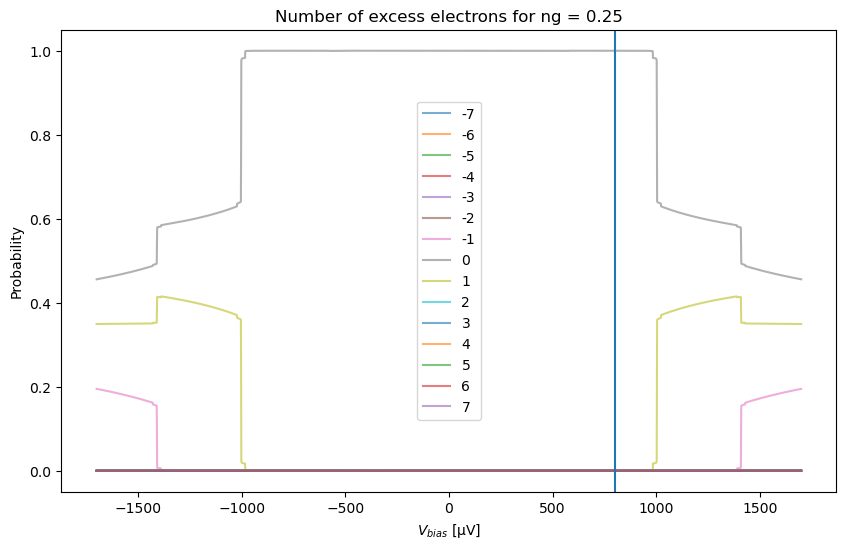

In [443]:
figure(figsize = (10,6))
for i in range(len(ne)):
    plot(v, probn[:,i], alpha = 0.6,label = str(ne[i]))
legend()
title(f'Number of excess electrons for ng = {ng}')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')
axvline(800)

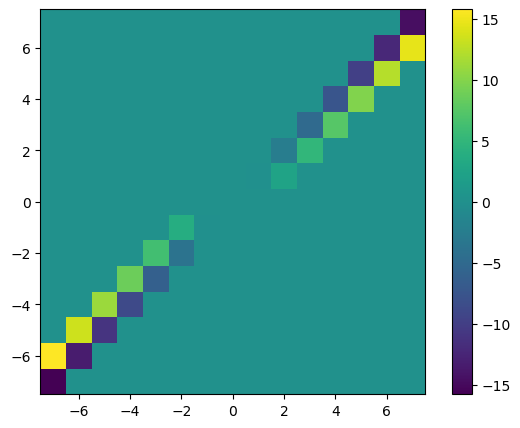

In [444]:
pcolormesh(ne,ne, Gmatrix[1700,:,:])
gca().set_aspect('equal')
colorbar()

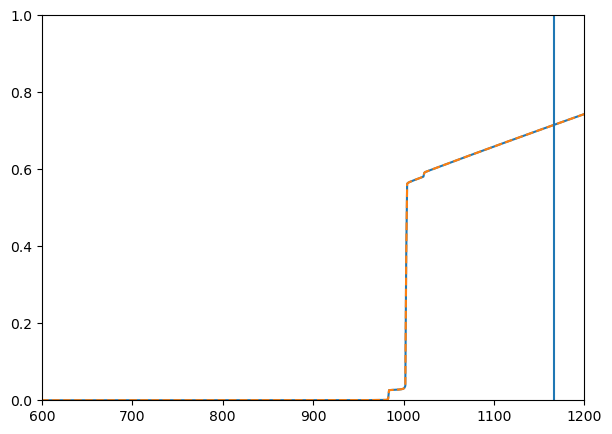

In [445]:
currempty = zeros_like(v)
for i in range(len(v)):
    currempty[i] = -sum(probn[i,:]*curr1junc[i,:])
plot(v, currempty)
czinterp = UnivariateSpline(v, currempty,k=1, s=0)
plot(v, czinterp(v), '--')
xlim(600,1200)
ylim(0,1)
axvline(4*200 + 2*Ec - 2*c.h*f/c.e*1e6)

### ng dependence

In [82]:
Zc = 4500
λ = sqrt(pi*Zc/Rk)
f = 10.811e9
v = arange(0,1200,0.5)
ne = arange(-7,8)
κ1 = 0.55
κ2 = 0.45
R=700e3
nph = 10
ntrunc = nph + 5
Ec=35
nglist = arange(-1.6,1.61,0.005)
currtotalng = zeros((len(nglist), len(v)))
for k, ng in enumerate(nglist):
    curr1junc = zeros((len(v), len(ne)))
    Gmatrix = zeros((len(v), len(ne), len(ne)))
    for i, nrow in enumerate(ne):
        for j, ncol in enumerate(ne):
            if nrow == ncol:
                Gmatrix[:, i, j] = - Gmphsum(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ) - Gpphsum(Ec, nrow, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            elif j - i == 1:
                Gmatrix[:, i, j] = Gmphsum(Ec, ncol,nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            elif j - i == - 1:
                Gmatrix[:, i, j] = Gpphsum(Ec, ncol, nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
            else:
                Gmatrix[:,i,j] = 0
        for kk in range(ntrunc+1):
            curr1junc[:,i] += (Gsn1ph(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ)-Gns1ph(Ec, nrow, nph, kk, ng, v, κ1, R, f, λ))
    Gmatrix[:,0,0] = Gmatrix[:,0,0] + Gmphsum(Ec, ne[0], nph,ntrunc, ng, v, κ1, κ2, R, f, λ)
    Gmatrix[:,-1,-1] = Gmatrix[:,-1,-1] + Gpphsum(Ec, ne[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
    Σ = zeros((len(ne),len(ne)))
    Σ[0] = ones(len(ne))
    svec = zeros(len(ne))
    ϵ = 1e-5
    svec[0] = ϵ
    probn = zeros((len(v),len(ne)))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gmatrix[i] + ϵ*Σ, svec)
    for i in range(len(v)):
        currtotalng[k,i] = -sum(probn[i,:]*curr1junc[i,:])

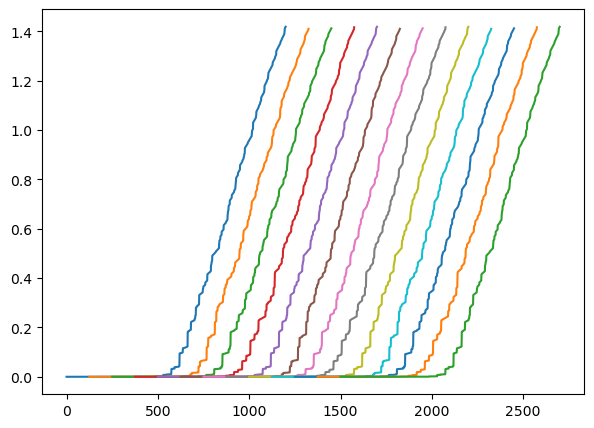

In [83]:
for i in range(len(nglist)):
    if i%50 == 0:
        plot(v+i*2.5, currtotalng[i,:], label = str(nglist[i]))
#plot(v, v*1e-6/R*0.7*1e9-0.4)

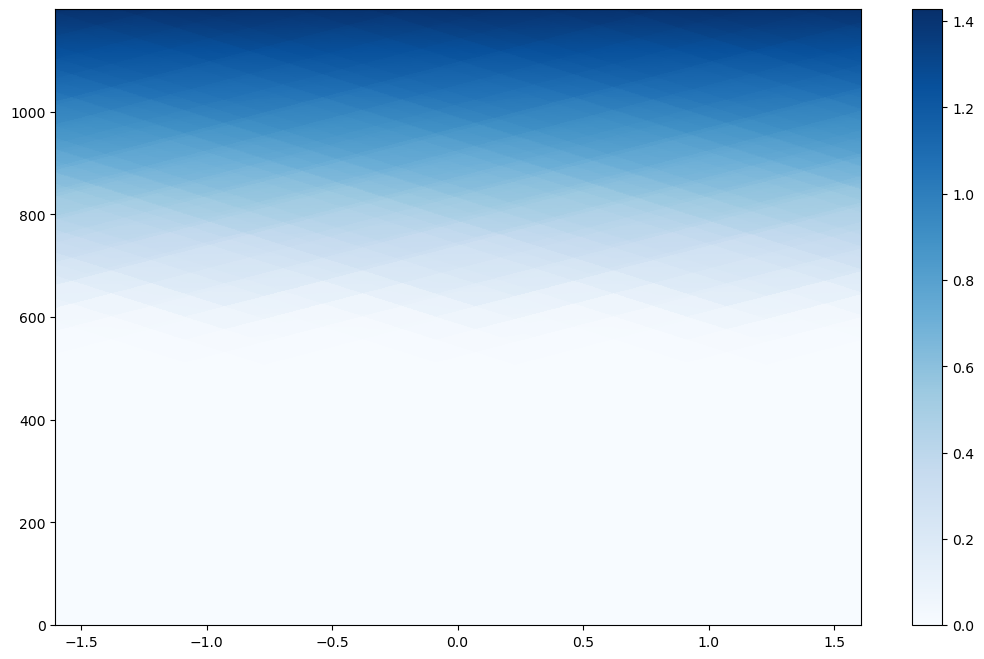

In [84]:
figure(figsize = (13,8))
pcolormesh(nglist, v, ((currtotalng.T)), cmap = 'Blues')
colorbar()
#axhline(800-nph*c.h*f/c.e*1e6)
#ylim(750, 1000)

(750.0, 1000.0)

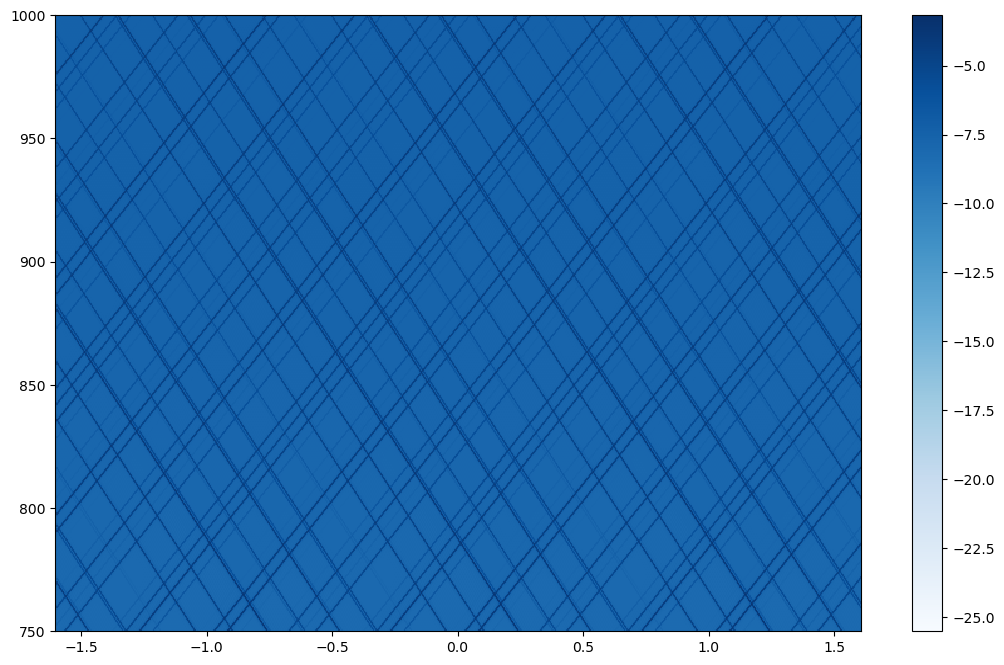

In [85]:
figure(figsize = (13,8))
pcolormesh(nglist, v, log(gradient(currtotalng.T, axis= 0)), cmap = 'Blues')
colorbar()
axhline(800-nph*c.h*f/c.e*1e6)
ylim(750, 1000)

### Resonator state not fixed

In [86]:
def Gsn1ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v+(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v+(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate

def Gns1ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate

def Gsn2ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate

def Gns2ph(Ec, ne, nph, nphend, ng, v, κ, R, f, λ):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v+(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph, nph - nphend, λ)
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v+(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*alphanl(nph,nphend-nph,λ)
    return rate

def Gmph(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f, λ):
    g = Gns1ph(Ec, ne, nph, nphend, ng, v, κ1, R, f, λ) + Gns2ph(Ec, ne, nph, nphend, ng, v, κ2, R, f, λ)
    return g

def Gpph(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f, λ):
    g = Gsn1ph(Ec, ne, nph, nphend, ng, v, κ1, R, f, λ) + Gsn2ph(Ec, ne, nph, nphend, ng, v, κ2, R, f, λ)
    return g

def Gpphsum(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gpph(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f, λ)
    return g

def Gmphsum(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f, λ):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gmph(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f, λ)
    return g

def Gnsummedres(ne, ne2):
    if ne == ne2:
        return - Gmphsum(Ec, ne, nph, nphmax, ng, v, κ1, κ2, R, f, λ) - Gpphsum(Ec, ne, nph, nphmax, ng, v, κ1, κ2, R, f, λ)
    if ne2 - ne == 1:
        return Gmphsum(Ec, ne2, nph, nphmax, ng, v, κ1, κ2, R, f, λ)
    elif ne2 - ne == -1:
        return Gpphsum(Ec, ne2, nph, nphmax, ng, v, κ1, κ2, R, f, λ)
    else:
        return 0
    
def Gmatfixedres(nph1, nph2, ne, ne2, nphotontrunc):
    if ne == ne2:
        if nph1 == nph2:
            return - Gmphsum(Ec, ne, nph1, nphotontrunc, ng, v, κ1, κ2, R, f, λ) - Gpphsum(Ec, ne, nph1, nphotontrunc, ng, v, κ1, κ2, R, f, λ)
        else:
            return 0
    if ne2 - ne == 1:
        return Gmph(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f, λ)
    elif ne2 - ne == -1:
        return Gpph(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f, λ)
    else:
        return 0
    

In [87]:
%%time
for i in range(1000):
    Gns2ph(Ec, 0, 0, 0, ng, -1000, κ1, R, f, λ)

CPU times: total: 78.1 ms
Wall time: 70 ms


In [88]:
Zc = 1500
λ = sqrt(pi*Zc/Rk)
f = 10.811e9
v = arange(-1500,2500,1, float)
κ1 = 0.5
κ2 = 0.5
R=700e3
nph = 2
nphmax = 5
ng = -2
Ec=133
ntrunc = nph + 5
eltrunc = 7
phstates = arange(ntrunc+1)
elstates = arange(-eltrunc, eltrunc + 1)
Gmat = zeros((len(v), len(elstates), len(elstates)))
for i , eli in enumerate(elstates):
    for j, elj in enumerate(elstates):
        Gmat[:, i,j] = Gnsummedres(eli, elj)
Gmat[:,0,0] += Gmphsum(Ec, elstates[0], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)
Gmat[:,-1,-1] += Gpphsum(Ec, elstates[-1], nph, ntrunc, ng, v, κ1, κ2, R, f, λ)

In [89]:
Σ = zeros((len(elstates),len(elstates)))
Σ[0] = ones(len(elstates))
svec = zeros(len(elstates))
ϵ = 1e-10
svec[0] = ϵ
probn = zeros((len(v),len(elstates)))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gmat[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

In [90]:
shape(Gmat)

(4000, 15, 15)

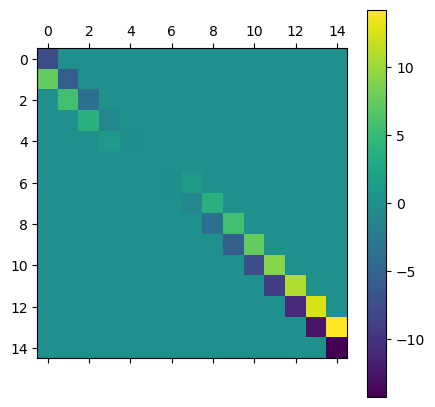

In [91]:
argv = argmin(abs(v-10))
#pcolormesh(elstates,elstates, Gmat[argv,:,:])
matshow(Gmat[argv,:,:])
gca().set_aspect('equal')
colorbar()

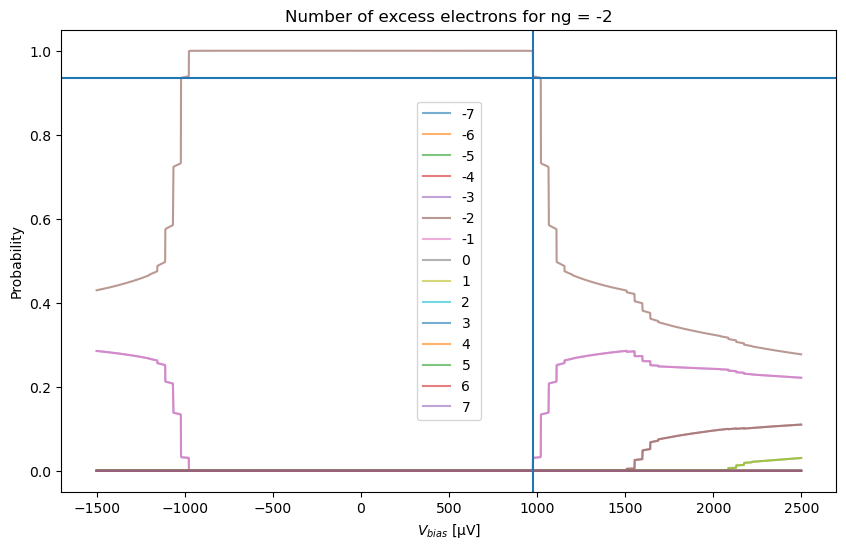

In [92]:
figure(figsize = (10,6))
for i in range(len(elstates)):
    plot(v, probn[:,i], alpha = 0.6,label = str(elstates[i]))
legend()
title(f'Number of excess electrons for ng = {ng}')
xlabel('$V_{bias}$ [µV]')
ylabel('Probability')
#savefig('Nng0p5.png')
#xlim(600,1200)
axvline(800+2*Ec-2*f*c.h/c.e*1e6)
axhline(0.935)

#### Creating a fixed photon number subspace matrix

In [105]:
%%time
Zc = 4500
λ = sqrt(pi*Zc/Rk)
λ = 0.3
f = 10.811e9
#v = arange(-1500,2500,1, float)
#v = [800.5+2*Ec+4.1*c.h*f/c.e*1e6]
v = [850.5]
κ1 = 0.5
κ2 = 0.5
R=700e3
ng = 0.25
Ec=133
ntrunc = 25
eltrunc = 10
phstates = arange(ntrunc+1)
elstates = arange(-eltrunc, eltrunc + 1)
Gmatfr = zeros((len(v), len(elstates), len(elstates),len(phstates), len(phstates)))
for ph1 in phstates:
    for ph2 in phstates:
        for i , eli in enumerate(elstates):
            for j, elj in enumerate(elstates):
                Gmatfr[:, i, j, ph1, ph2] = Gmatfixedres(ph1, ph2, eli, elj, ntrunc)
        #Gmatfr[:,0,0, ph1, ph2] += Gmphsum(Ec, elstates[0], ph2, ntrunc, ng, v, κ1, κ2, R, f, λ)
        #Gmatfr[:,-1,-1, ph1, ph2] += Gpphsum(Ec, elstates[-1], ph2, ntrunc, ng, v, κ1, κ2, R, f, λ)


CPU times: total: 15.8 s
Wall time: 15.8 s


In [106]:
Gtotaltry = zeros((len(v), (ntrunc+1)*(2*eltrunc+1), (ntrunc+1)*(2*eltrunc+1)))
print(shape(Gmatfr))
print(shape(Gtotaltry))
for i1 in range(ntrunc+1):
    for i2 in range(ntrunc+1):
        Gtotaltry[:,i2*len(elstates):(i2+1)*len(elstates),i1*len(elstates):(i1+1)*len(elstates)] = Gmatfr[:,:,:,i1,i2]

(1, 21, 21, 26, 26)
(1, 546, 546)


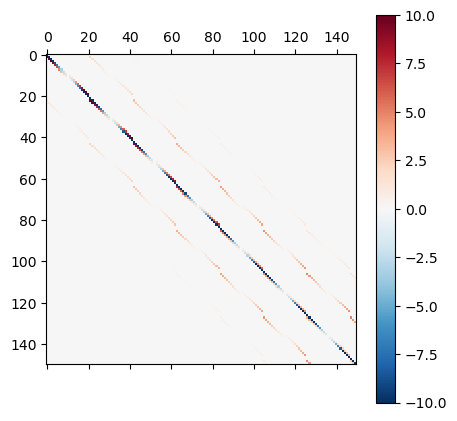

In [107]:
matshow(Gtotaltry[0, :150, :150], cmap = 'RdBu_r', vmin = -10, vmax = 10)
gca().set_aspect('equal')
colorbar()

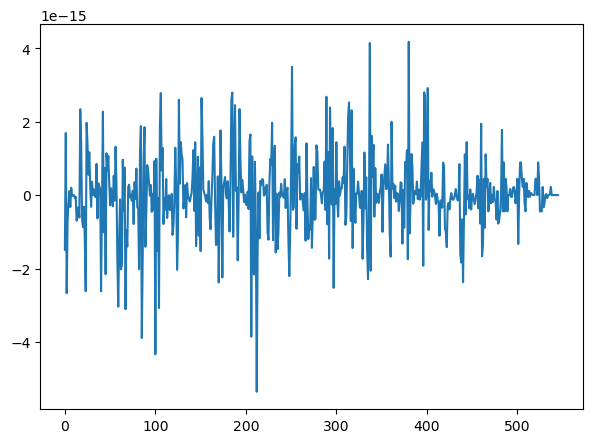

In [108]:
A = Gtotaltry[0,:,:]
plot(A.sum(0))
#ylim(-1,1)

In [109]:
Σ = zeros((len(elstates)*len(phstates),len(elstates)*len(phstates)))
Σ[0] = ones(len(elstates)*len(phstates))
svec = zeros(len(elstates)*len(phstates))
ϵ = 1e-10
svec[0] = ϵ
probn = zeros((len(v),len(elstates)*len(phstates)))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gtotaltry[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

Text(0, 0.5, 'Photon number')

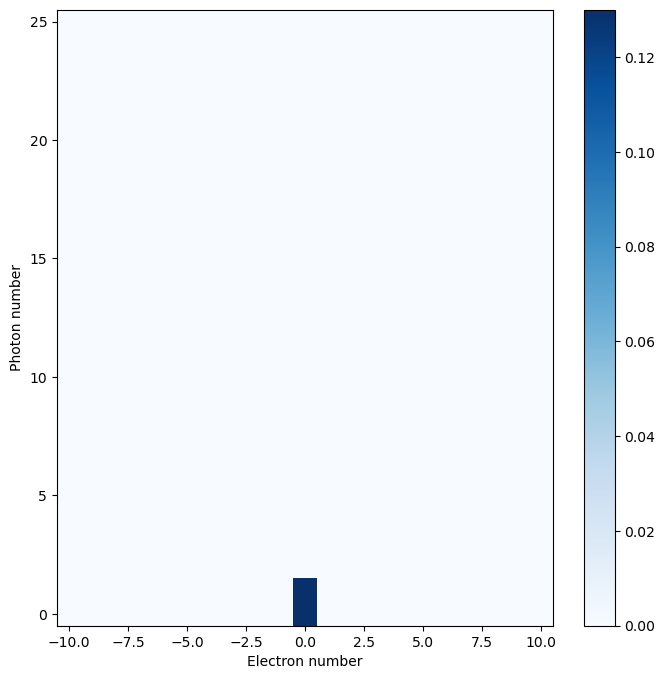

In [110]:
fig, ax = subplots(figsize = (8,8))
pnm = reshape(probn, (len(phstates),len(elstates)))
pcolormesh(elstates, phstates, pnm, vmin = 0, vmax = 0.13, cmap = 'Blues')
colorbar()
#gca().set_aspect(1)
xlabel('Electron number')
ylabel('Photon number')
#colorbar()

# Optimization of P(ne, nph) master equation

In [112]:
def RateSISIS(E, dE, dyn, delta, Tn, Ts):
    return  dynesDOS(E-dE, dyn, delta)*dynesDOS(E, dyn, delta)*(1-fdd(E, Tn))*fdd(E-dE, Ts)

In [599]:
dyn = 1e-1
deltaAl = 200
Ts = 0.05
Tn = 0.05
Ec = 133
SISISparams = (dyn, deltaAl, Tn, Ts)

In [600]:
%%time
maxe = 3200
de = 0.02
vn = arange(-20, 2*deltaAl-20, 2)
vn2 = arange(2*deltaAl-20, 2*deltaAl+20, 0.05)
v = r_[arange(-1600, -20, 5), vn, vn2, arange(2*deltaAl+20, 1600, 20)]
ratearr = zeros_like(v, dtype = float)
E = arange(-maxe, maxe, de, dtype=float)
for i in range(len(v)):
    ratearr[i] = trapz(RateSISIS(E,v[i],*SISISparams))*de
Rateinterp = UnivariateSpline(v, ratearr,k=1, s=0)

C:\Users\stanisavljevic\AppData\Local\Temp\ipykernel_16560\204757762.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(exp((E-mu)*c.e*1e-6/c.k/T)+1)


CPU times: total: 1min 21s
Wall time: 1min 21s


In [826]:
Zc = 500
Rk = 25812
#λ = sqrt(pi*Zc/Rk)
λ = 0.0008
%time Lag = generateLaguerrearray(50, λ)

CPU times: total: 453 ms
Wall time: 464 ms


In [827]:
phlossrate = 1.5e7*2*pi
def Gsn1phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    return rate

def Gns1phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

def Gsn2phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2+(ne-ng))-κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

def Gns2phopt(Ec, ne, nph, nphend, ng, v, κ, R, f):
    if nphend < 0:
        return 0
    elif nph > nphend:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph, nph - nphend]/c.e*1e-9
    else:
        rate = Rateinterp(-(2*Ec*(1/2-(ne-ng))+κ*(v-(nphend-nph)*c.h*f/c.e*1e6)))*1e3/((κ)*R)*Lag[nph,nphend-nph]/c.e*1e-9
    return rate

def Gmphopt(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f):
    g = Gns1phopt(Ec, ne, nph, nphend, ng, v, κ1, R, f) + Gns2phopt(Ec, ne, nph, nphend, ng, v, κ2, R, f)
    return g

def Gpphopt(Ec, ne, nph, nphend, ng, v, κ1, κ2, R, f):
    g = Gsn1phopt(Ec, ne, nph, nphend, ng, v, κ1, R, f) + Gsn2phopt(Ec, ne, nph, nphend, ng, v, κ2, R, f)
    return g

def Gpphsumopt(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gpphopt(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f)
    return g

def Gmphsumopt(Ec, ne, nph, ntrunc, ng, v, κ1, κ2, R, f):
    g = zeros_like(v)
    for kk in range(ntrunc+1):
        g += Gmphopt(Ec, ne, nph, kk, ng, v, κ1, κ2, R, f)
    return g

def Gnsummedresopt(ne, ne2):
    if ne == ne2:
        return - Gmphsumopt(Ec, ne, nph, nphmax, ng, v, κ1, κ2, R, f) - Gpphsumopt(Ec, ne, nph, nphmax, ng, v, κ1, κ2, R, f)
    if ne2 - ne == 1:
        return Gmphsumopt(Ec, ne2, nph, nphmax, ng, v, κ1, κ2, R, f)
    elif ne2 - ne == -1:
        return Gpphsumopt(Ec, ne2, nph, nphmax, ng, v, κ1, κ2, R, f)
    else:
        return 0
    
def Gmatfixedresopt(nph1, nph2, ne, ne2, nphotontrunc):
    if ne == ne2:
        if nph1 == nph2:
            return - Gmphsumopt(Ec, ne, nph1, nphotontrunc, ng, v, κ1, κ2, R, f) - Gpphsumopt(Ec, ne, nph1, nphotontrunc, ng, v, κ1, κ2, R, f)
        elif nph2 == nph1 - 1:
            return nph1 * phlossrate
        else:
            return 0
    if ne2 - ne == 1:
        return Gmphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    elif ne2 - ne == -1:
        return Gpphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    else:
        return 0

def Gmatfixedresoptnondiag(nph1, nph2, ne, ne2, nphotontrunc):
    if ne == ne2:
        if nph2 == nph1 - 1:
            return nph1* phlossrate
        if nph2 == nph - 2:
            return nph1 * phlossrate / 2
        if nph2 == nph - 3:
            return nph1 * phlossrate / 3
        else:
            return 0
    if ne2 - ne == 1:
        return Gmphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    elif ne2 - ne == -1:
        return Gpphopt(Ec, ne2, nph1, nph2, ng, v, κ1, κ2, R, f)
    else:
        return 0

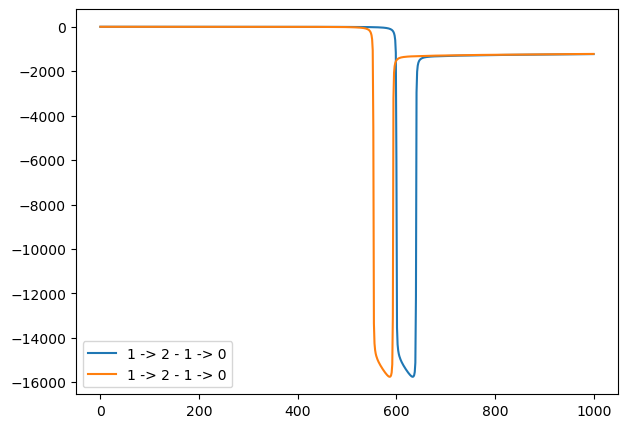

In [828]:
ng = 0.3
v = arange(0,1000, 1.2)
plot(v, Gmatfixedresopt(4, 5, 0, 1, 10) - Gmatfixedresopt(4, 3, 0, 1, 10), label = '1 -> 2 - 1 -> 0')
ng = 0.1
plot(v, Gmatfixedresopt(4, 5, 0, 1, 10) - Gmatfixedresopt(4, 3, 0, 1, 10), label = '1 -> 2 - 1 -> 0')
legend()

#### Creating a fixed photon number subspace matrix

In [829]:
v = arange(750,1330,2, float)
ntrunc = 10
eltrunc = 6
phstates = arange(ntrunc+1)
elstates = arange(-eltrunc, eltrunc + 1)
#v = [800.5+2*Ec+4.1*c.h*f/c.e*1e6]
Σ = zeros((len(elstates)*len(phstates),len(elstates)*len(phstates)))
Σ[0] = ones(len(elstates)*len(phstates))
svec = zeros(len(elstates)*len(phstates))
ϵ = 1e-3
svec[0] = ϵ
f = 4.811e9
κ1 = 0.6
κ2 = 0.4
R=700e3
#ng = 0
nglist = [0.4]
Ec=70
meanphmap = zeros((len(nglist), len(v)))

In [830]:
%%time
for ngi, ng in enumerate(nglist):
    Gmatfr = zeros((len(v), len(elstates), len(elstates),len(phstates), len(phstates)))
    Gtotaltry = zeros((len(v),len(elstates)*len(phstates),len(elstates)*len(phstates)))
    for ph1 in phstates:
        for ph2 in phstates:
            for i , eli in enumerate(elstates):
                for j, elj in enumerate(elstates):
                    Gmatfr[:, i, j, ph1, ph2] = Gmatfixedresoptnondiag(ph1, ph2, eli, elj, ntrunc)
    for i1 in range(ntrunc+1):
        for i2 in range(ntrunc+1):
            Gtotaltry[:,i2*len(elstates):(i2+1)*len(elstates),i1*len(elstates):(i1+1)*len(elstates)] = Gmatfr[:,:,:,i1,i2]
    #for kk in range(len(v)):
    for i in range(Gtotaltry.shape[2]):
        Gtotaltry[:,i,i] = -sum(Gtotaltry[:,:,i], axis = 1)
    probn = zeros((len(v),len(elstates)*len(phstates)))
    for i in range(len(v)):
        probn[i,:] = linalg.solve(Gtotaltry[i] + ϵ*Σ, svec)
        pnm = reshape(probn[i,:], (len(phstates),len(elstates)))
        meanphmap[ngi, i] = mean(pnm.sum(1)*phstates)

CPU times: total: 266 ms
Wall time: 264 ms


Text(0.5, 1.0, 'Mean photon number as function of gate and bias')

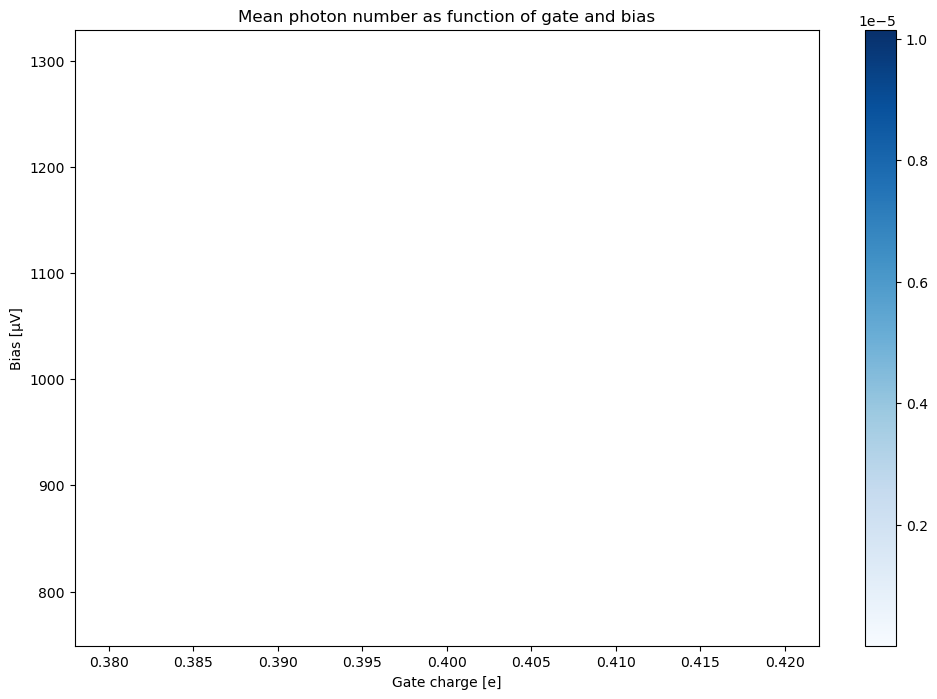

In [831]:
figure(figsize = (12, 8))
pcolormesh(nglist, v, gf(meanphmap.T, (2,2)), cmap = 'Blues')
colorbar()
ylabel('Bias [µV]')
xlabel('Gate charge [e]')
title('Mean photon number as function of gate and bias')

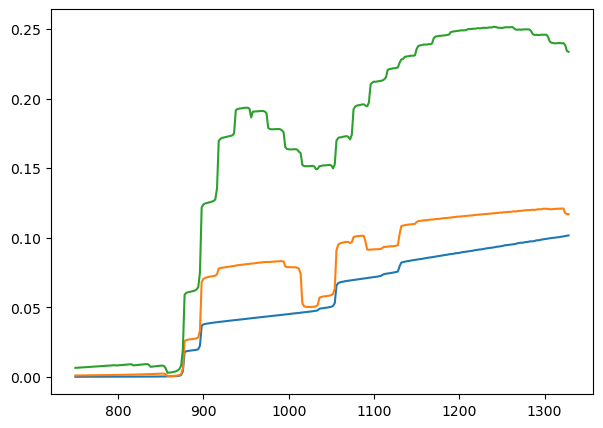

In [836]:
#meanphl2 = meanphmap[0,:]
plot(v, meanphmap[0,:]*10000)
plot(v, meanphl1)
plot(v, meanphl2)

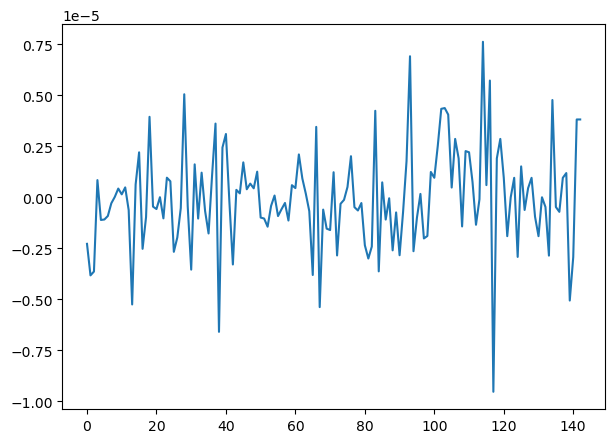

In [720]:
A = Gtotaltry[100,:,:]
plot(A.sum(0))
#ylim(-1,1)

(0.0, 1.04)

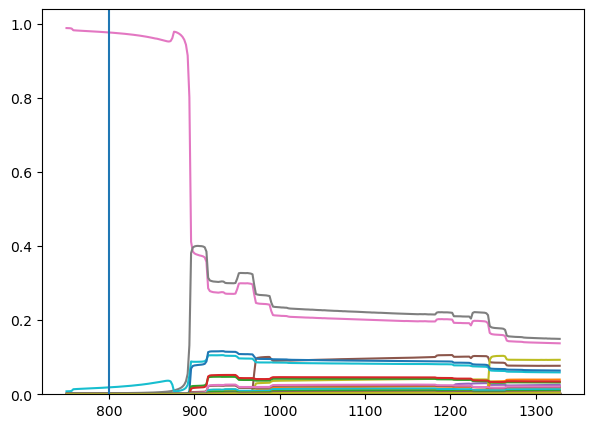

In [749]:
for kk in range(99):
    plot(v, probn[:,kk])
axvline(800)
ylim(0,1.04)

Text(0, 0.5, 'Photon number')

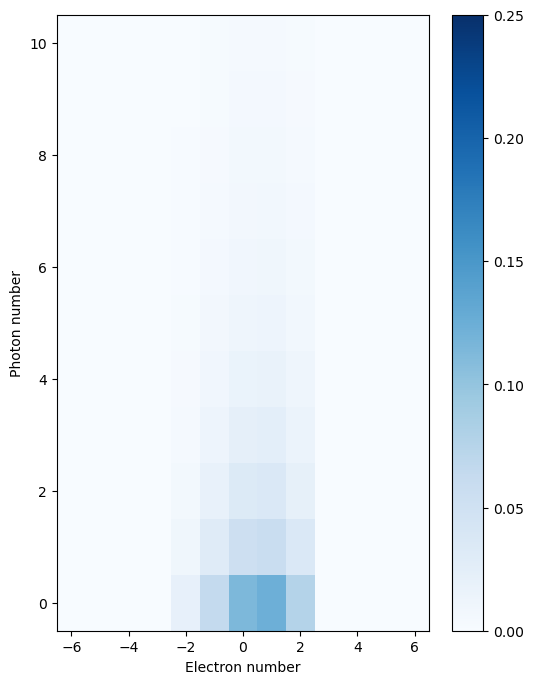

In [757]:
vtry = 1750
vi = argmin(abs(v-vtry))
fig, ax = subplots(figsize = (6,8))
pnm = reshape(probn[vi,:], (len(phstates),len(elstates)))
pcolormesh(elstates, phstates, pnm, vmin = 0, vmax = 0.25, cmap = 'Blues')
colorbar()
#gca().set_aspect(1)
xlabel('Electron number')
ylabel('Photon number')
#colorbar()

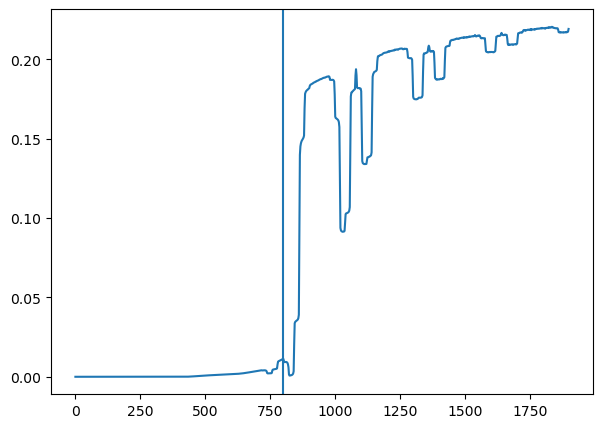

In [668]:
meanphno = zeros_like(v)
for i in range(len(v)): 
       pnm = reshape(probn[i,:], (len(phstates),len(elstates)))
       meanphno[i] = mean(pnm.sum(1)*phstates)
plot(v, meanphno)
axvline(800+0*c.h*f/c.e*1e6)

In [590]:
mean(pnm.sum(1))

0.06251128390701263

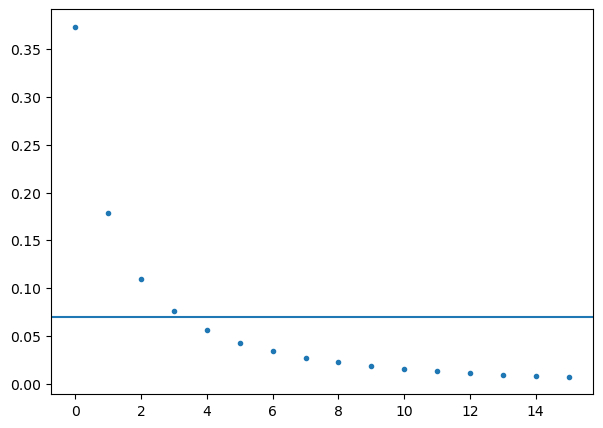

In [589]:
plot(phstates, pnm.sum(1), '.')
#ylim(-1e-2,1+1e-2)
#semilogy()
axhline(0.07)

In [674]:
v = arange(-2000, 2000, 0.1)

In [675]:
%%time 
for ii in range(9801):
    a = argmin(abs(v-785.431))

CPU times: total: 750 ms
Wall time: 762 ms


0

In [724]:
Gtotaltry[0,10,10]

-1.3230213671207935

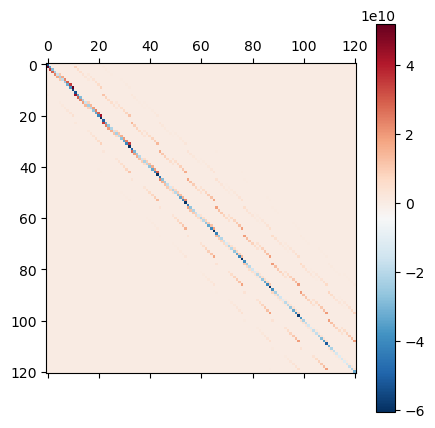

In [153]:
matshow(Gtotaltry[99,:,:], cmap = 'RdBu_r')
gca().set_aspect('equal')
colorbar()

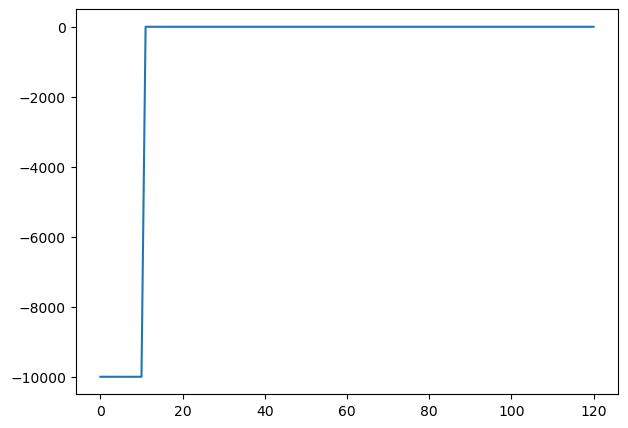

In [907]:
A = Gtotaltry[500,:,:]
plot(A.sum(0))
#ylim(-1,1)

In [621]:
Σ = zeros((len(elstates)*len(phstates),len(elstates)*len(phstates)))
Σ[0] = ones(len(elstates)*len(phstates))
svec = zeros(len(elstates)*len(phstates))
ϵ = 1e-10
svec[0] = ϵ
probn = zeros((len(v),len(elstates)*len(phstates)))
for i in range(len(v)):
    probn[i,:] = linalg.solve(Gtotaltry[i] + ϵ*Σ, svec)
    #probn[i,:] = abs(null_space(Gmatmasked[i,:,:]).flatten()/sum(null_space(Gmatmasked[i,:,:]).flatten()))

Text(0, 0.5, 'Photon number')

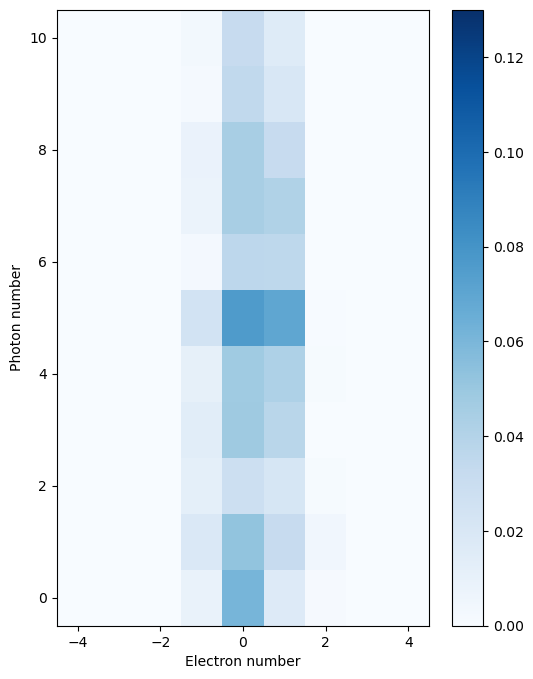

In [622]:
fig, ax = subplots(figsize = (6,8))
pnm = reshape(probn, (len(phstates),len(elstates)))
pcolormesh(elstates, phstates, pnm, vmin = 0, vmax = 0.13, cmap = 'Blues')
colorbar()
#gca().set_aspect(1)
xlabel('Electron number')
ylabel('Photon number')
#colorbar()

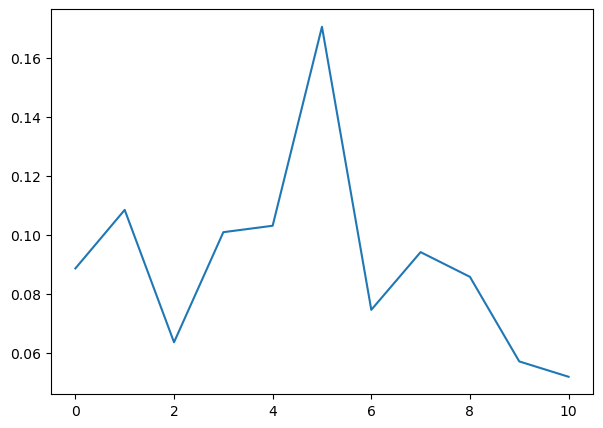

In [623]:
plot(pnm.sum(1))